# Jupyter Notebook for Cross-Calibration Analysis

This notebook performs correlation analysis between **SOHO/ERNE** and **IMP-8/GME** instruments for proton energies above **100 MeV**.  
Developed with help from **Rami Vainio, Esa Riihonen, and Philipp Oleynik**. This notebook may serve as a template for any further work in cross-calibration between different events or new data sets.

---

## 📂 Data Sources
- **SOHO/ERNE**  
  - Contact: *Esa Riihonen* ([riihonen@utu.fi](mailto:riihonen@utu.fi))  
  - Address: Vesilinnantie 5, 20500 Turku  

- **IMP-8/GME**  
  - **NASA CDAWeb** ([Website](https://cdaweb.gsfc.nasa.gov/istp_public/))  
  - NASA Official: *Robert M. Candey* ([Robert.M.Candey@nasa.gov](mailto:Robert.M.Candey@nasa.gov))  
  - Curator: *Tami Kovalick*  

---

## 📖 Notebook Overview
This notebook is structured as follows:  

1. [🔹 Import Required Libraries](##📌-Import-Required-Libraries)  
2. [🔹 Installing Required Libraries](##⚙️-Installing-Required-Libraries)  
3. [🔹 Extracting GME Data](#🚀-Extracting-GME-Data)
4. [🔹 Loading and Preprocessing ERNE Data](#📊-Loading-and-Preprocessing-ERNE-Data)
    - [🔹 Filtering Data to Match ERNE Dates](#🔍-Filtering-Data-to-Match-ERNE-Dates)
    - [🔹 Filtering Data by Date Range](#🔍-Filtering-Data-by-Date-Range)
    - [🔹 Define Highlighted Event Ranges](#📅-Define-Highlighted-Event-Ranges)
    - [🔹 Background Reduction](#🛠%EF%B8%8F-Background-Reduction)
    - [🔹 Calculate Statistical Errors](#📊-Calculate-Statistical-Errors)
5. [🔹 Analyzing <font color='blue'>"Blue"</font> Event as an Example](#🔵-Analyzing-"Blue"-Event-as-an-Example)
    - [🔹 RANSAC](#RANSAC)
    - [🔹 Plotting Outliers and Inliers](#Plotting-Outliers-and-Inliers)
    - [🔹 Intensity as a Function of Energy](#Intensity-as-a-Function-of-Energy)
    - [🔹 Calculate values of `c`](#Calculate-values-of-c)
    - [🔹 Correlation Fit With ERNE rate and GME intensity](#Correlation-Fit-With-ERNE-rate-and-GME-intensity)
    - [🔹 Orthogonal Distance Regression](#Orthogonal-Distance-Regression)
11. [🔹 Analyzing Results](#📊-Analyzing-Results)
    - [🔹 Measuring Chi-Squared ($\chi^2$) ](#🔎-Measuring-Chi-Squared-($\chi^2$))
    - [🔹 Average intensity as a function of energy](#📈-Average-intensity-as-a-function-of-energy)
    - [🔹 Compiling & Analyzing Calibration Coefficients  ](#📊-Compiling-&-Analyzing-Calibration-Coefficients)
---

## 📌 Import Required Libraries  

This section loads essential Python libraries for:  
- **Data Handling** → `pandas` (structured data manipulation)  
- **File Operations** → `tarfile`, `os` (handling compressed datasets)  
- **Data Visualization** → `matplotlib` (generating plots & graphs)  
- **etc...**

## ⚙️ Installing Required Libraries
If you do not have a required library installed, you can install it using a Jupyter Notebook cell.
For example, to install NumPy, run the following command inside a notebook cell:
```python
!pip install numpy
```
For conda users, you can use:
```python
!conda install numpy -y
```
<div class="alert alert-block alert-info">
<b>Note:</b> Ensure all required libraries are installed before proceeding. 
</div>

In [1]:
# !pip install numpy

***

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RANSACRegressor
import re
import tarfile
import os
from matplotlib.dates import AutoDateLocator, DateFormatter
import statsmodels.api as sm
from sklearn.metrics import r2_score
from scipy.odr import ODR, Model, RealData

# 🚀 Extracting GME Data

This section extracts the **IMP-8/GME dataset** from a compressed `.tar.gz` file, and shows examples of plotting the data.  

### 📌 Key Steps:
1. **Modify the dataset path** → Update `tar_gz_file` if stored elsewhere.  
2. **Define energy levels** → These correspond to flux measurement channels in MeV.  
3. **Load data into a Pandas DataFrame** → The first two columns contain timestamps & cadence info, while the remaining columns represent different energy levels.  
4. **Filter data based on time range** → Modify `start_date` and `end_date` to analyze specific periods.  
5. **Customize date ranges for analysis** → The `date_ranges` variable defines different periods for study.  
6. **Highlight specific event windows** → `highlight_ranges` marks sub-periods within the main date range for focused analysis.  
7. **Select an energy channel** → Modify `i` to explore different energy channels.

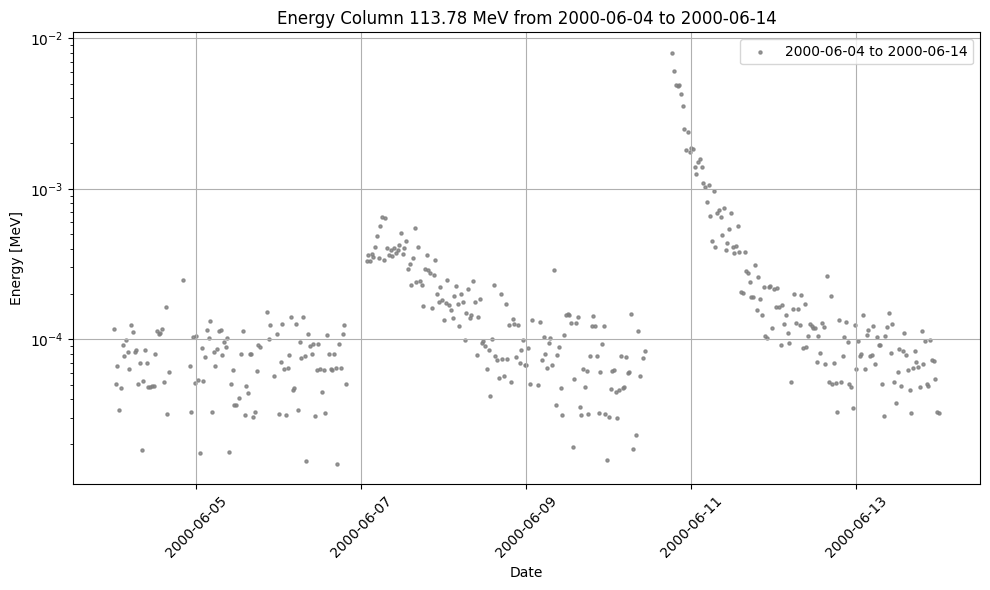

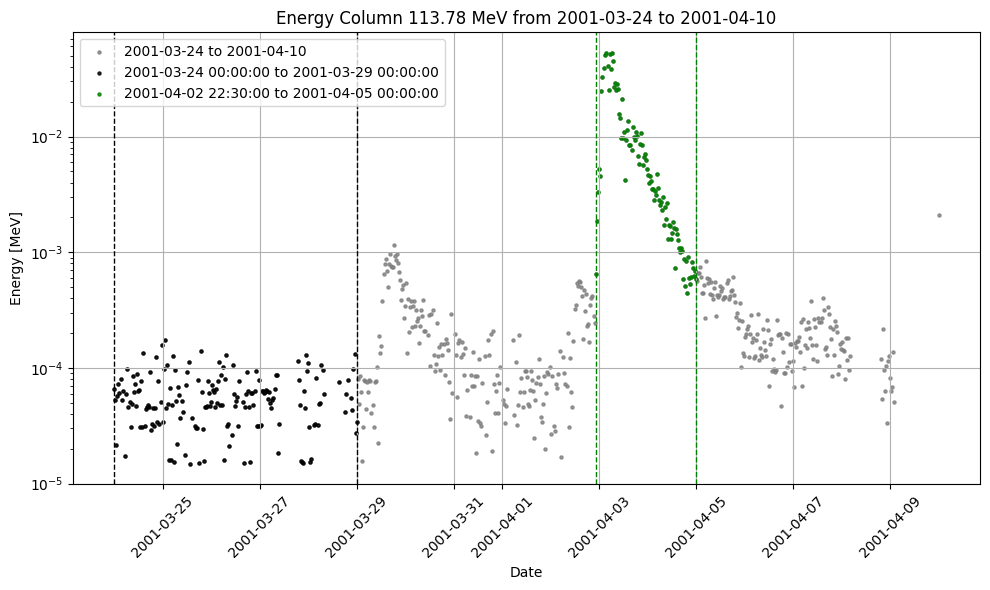

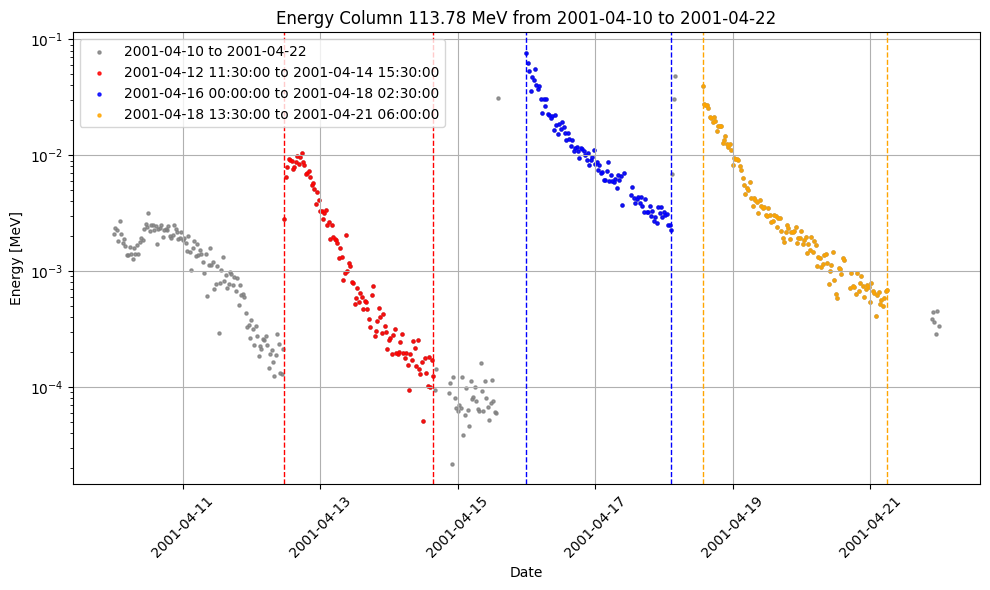

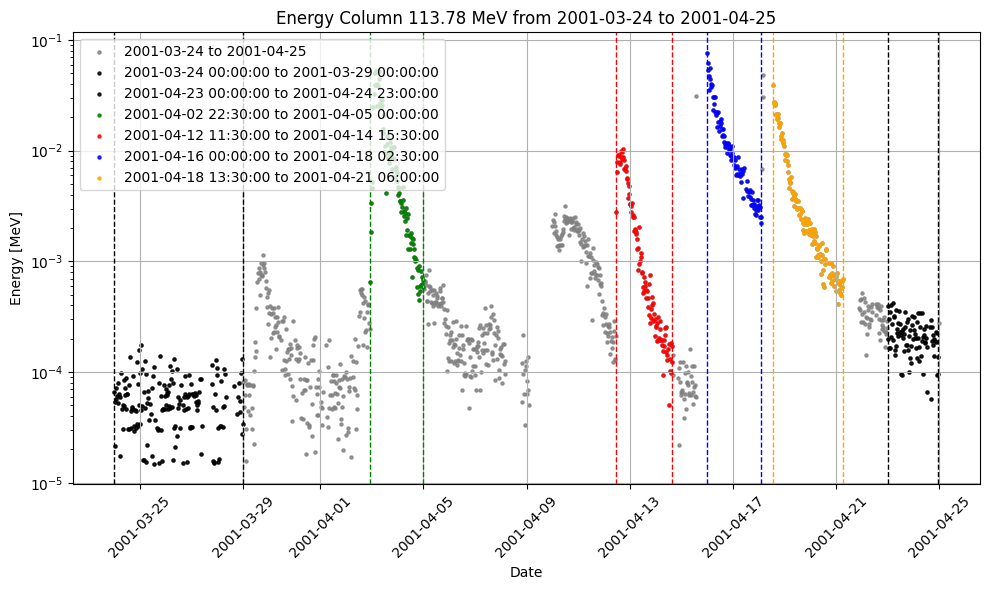

In [3]:
# path to the tar.gz
tar_gz_file = "IMP8_datasets.tar.gz"

# open tar.gz file
with tarfile.open(tar_gz_file, "r:gz") as tar:
    # extract contents to the current directory
    tar.extractall()

imp8_file = os.path.join("IMP8.txt")

# Energy values for flux columns
energy_values = [1.01, 1.28, 1.6, 2.02, 2.62, 3.57, 4.55, 5.43, 6.57, 7.92, 9.8, 12.29, 14.8, 17.35, 20.51, 
                 21.89, 26.35, 31.78, 38.86, 46.77, 56.77, 71.55, 89.71, 113.78, 136.51, 165.57, 202.34, 274.24, 398.24]

# def the column names 
column_names = [
    "date_time", "cadence"
] + [str(energy) for energy in energy_values]

# files into pandas df 
imp8_df = pd.read_csv(imp8_file, sep=',', names=column_names, parse_dates=["date_time"])

# def the date range
start_date = "2000-04-20 00:00:00"
end_date = "2001-04-24 23:30:00"

# Filter the rows based on the date range
filtered_imp8_df = imp8_df[(imp8_df["date_time"] >= start_date) & (imp8_df["date_time"] <= end_date)]

# Create new data frames with the filtered rows
imp8_df_00 = filtered_imp8_df.copy()

imp8_df_00.reset_index(drop=True, inplace=True)

# Display the first few rows of the new data frames to verify
# print("Filtered IMP8 Data:")

# def the date ranges
date_ranges = [
    ("2000-06-04", "2000-06-14"),
    ("2001-03-24", "2001-04-10"),
    ("2001-04-10", "2001-04-22"),
    ("2001-03-24", "2001-04-25"),
]

highlight_ranges = [
    ("2001-03-24 00:00:00", "2001-03-29 00:00:00", 'black'),
    ("2001-04-23 00:00:00", "2001-04-24 23:00:00", 'black'),
    ("2001-04-02 22:30:00", "2001-04-05 00:00:00", 'green'),
    ("2001-04-12 11:30:00", "2001-04-14 15:30:00", 'red'),
    ("2001-04-16 00:00:00", "2001-04-18 02:30:00", 'blue'),
    ("2001-04-18 13:30:00", "2001-04-21 06:00:00", 'orange')
]

# Select the column to plot
i = 25

# Plotting each date range separately
for start_date, end_date in date_ranges:
    range_df = imp8_df_00[(imp8_df_00["date_time"] >= start_date) & (imp8_df_00["date_time"] <= end_date)]
    
    plt.figure(figsize=(10, 6))
    
    # Scatter plot for all points in the current date range
    plt.scatter(range_df['date_time'], range_df.iloc[:, i], color='gray', label=f'{start_date} to {end_date}', alpha=0.8, s=5)

    # Highlight specific sub-ranges within the current plot
    for h_start, h_end, color in highlight_ranges:
        sub_range_df = range_df[(range_df["date_time"] >= h_start) & (range_df["date_time"] <= h_end)]
        if not sub_range_df.empty:
            plt.scatter(sub_range_df['date_time'], sub_range_df.iloc[:, i], color=color, label=f'{h_start} to {h_end}', alpha=0.8, s=5)
            
            # Add vertical dashed lines for the start and end of each sub-range
            plt.axvline(pd.to_datetime(h_start), color=color, linestyle='--', linewidth=1)
            plt.axvline(pd.to_datetime(h_end), color=color, linestyle='--', linewidth=1)

    plt.title(f'Energy Column {imp8_df.iloc[:, i].name} MeV from {start_date} to {end_date}')
    plt.xlabel('Date')
    plt.ylabel('Energy [MeV]')
    plt.yscale('log')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

---

# 📊 Loading and Preprocessing ERNE Data
This section loads the ERNE dataset from a CSV file, extracts timestamps, and adjusts date formats to ensure consistency with the GME dataset.

### Steps:
1. **Read ERNE CSV file** → Load `ERNE_2000-04-20_2001-04-25_counts.csv` into a Pandas DataFrame. 💡 *Check that the file name and directory are corrrect* 
3. **Convert timestamps** → Ensure datetime format consistency.
4. **Adjust timestamps** → Subtract `15 minutes` from each timestamp.
5. **Convert back to string format** → For easy comparisons.

<div class="alert alert-block alert-danger">
<b>Note!:</b> These changes are specific to comparing ERNE and GME, if you are using different datasets the timestamp change will most likely be different.
</div>

Lastly we synchronize GME Dates with ERNE modifying the GME dataset to ensure date formats are consistent.

In [4]:
# Read csv file and print, suppressing memory warnings for large files
df2 = pd.read_csv('ERNE_2000-04-20_2001-04-25_counts.csv', low_memory=False)

# Extract only the date column, skipping the first two rows
df2_dates = df2.iloc[2:, :1].copy()

# Convert the first column to datetime and subtract 15 minutes
df2_dates["adjusted_date_time"] = pd.to_datetime(df2_dates["Unnamed: 0"]) - pd.Timedelta(minutes=15)

# Format to match the date format used in the IMP-8 dataset
df2_dates["adjusted_date_time"] = df2_dates["adjusted_date_time"].dt.strftime('%Y-%m-%d %H:%M:%S')

# Convert IMP-8 dates to the same format as ERNE
imp8_df_00["date_time"] = pd.to_datetime(imp8_df_00["date_time"]).dt.strftime('%Y-%m-%d %H:%M:%S')

## 🔍 Filtering Data to Match ERNE Dates
To ensure alignment between **GME** and **ERNE datasets**, we filter the GME dataset to retain only timestamps that match the adjusted ERNE data.

### 📌 Key Actions:
1. **Filter GME data** → Keep only rows matching ERNE timestamps.
2. **Extract relevant** ERNE columns → Focus on `AC1 (TOT)` and `AC1 (D1>1.3MeV)`, which correspond to different energy channels.
3. **Add event count columns** → Representing total event counts.

In [5]:
# Filter the IMP-8 dataset to keep only the rows where the date-time matches the adjusted ERNE timestamps
filtered_new_imp8_df = imp8_df_00[imp8_df_00["date_time"].isin(df2_dates["adjusted_date_time"])]

# Adding ERNE Data 
df2_ac1_tot = df2.iloc[2:, [1]].copy()
df2_ac1_d1_13mev = df2.iloc[2:, [3]].copy()
df2_count_tot = df2.iloc[2:, [5]].copy()
df2_count_ac1_d1_13mev = df2.iloc[2:, [7]].copy()

# Rename columns for clarity
df2_ac1_tot.columns = ["AC1 (TOT)"]
df2_ac1_d1_13mev.columns = ["AC1 (D1>1.3MeV)"]
df2_count_tot.columns = ["count (TOT)"]
df2_count_ac1_d1_13mev.columns = ["count AC1 (D1>1.3MeV)"]

# Reset indices to ensure smooth concatenation
df2_ac1_tot.reset_index(drop=True, inplace=True)
df2_ac1_d1_13mev.reset_index(drop=True, inplace=True)
df2_count_tot.reset_index(drop=True, inplace=True)
df2_count_ac1_d1_13mev.reset_index(drop=True, inplace=True)

# Reset index for the filtered IMP-8 dataset
filtered_new_imp8_df.reset_index(drop=True, inplace=True)

# Concatenate ERNE data with the filtered IMP-8 dataset
filtered_new_imp8_df = pd.concat([filtered_new_imp8_df, df2_ac1_tot, df2_ac1_d1_13mev, df2_count_tot, df2_count_ac1_d1_13mev], axis=1)

# Print first few rows of the updated dataset
print("Updated IMP8 Data:")
print(filtered_new_imp8_df.head())

Updated IMP8 Data:
             date_time  cadence   1.01   1.28  1.6   2.02  2.62  3.57  4.55  \
0  2000-04-20 00:00:00     1800    NaN    NaN  NaN    NaN   NaN   NaN   NaN   
1  2000-04-20 00:30:00     1800  0.265  0.511  0.0  0.149   0.0   0.0   0.0   
2  2000-04-20 01:00:00     1800    NaN    NaN  NaN    NaN   NaN   NaN   NaN   
3  2000-04-20 01:30:00     1800    NaN    NaN  NaN    NaN   NaN   NaN   NaN   
4  2000-04-20 02:00:00     1800    NaN    NaN  NaN    NaN   NaN   NaN   NaN   

   5.43  ...  113.78  136.51    165.57    202.34    274.24    398.24  \
0   NaN  ...     NaN     NaN       NaN       NaN       NaN       NaN   
1   0.0  ...     NaN     0.0  0.000142  0.000187  0.000096  0.000115   
2   NaN  ...     NaN     NaN       NaN       NaN       NaN       NaN   
3   NaN  ...     NaN     NaN       NaN       NaN       NaN       NaN   
4   NaN  ...     NaN     NaN       NaN       NaN       NaN       NaN   

            AC1 (TOT)     AC1 (D1>1.3MeV)  count (TOT)  count AC1 (D1>1.3

## 🔍 Filtering Data by Date Range

Define the start and end dates for analysis `start_date` and `end_date` and filter the DataFrame within the specified date range
print out commented out to conserve space.

In [6]:
start_date = "2001-03-24"
end_date = "2001-04-24"

# Filter the DataFrame based on the specified date range, reset index for consistency
data_2001 = filtered_new_imp8_df[(filtered_new_imp8_df["date_time"] >= start_date) & (filtered_new_imp8_df["date_time"] <= end_date)]
data_2001.reset_index(drop=True, inplace=True)

# Print out the filtered data
# print(data_2001.head())

## 📅 Define Highlighted Event Ranges

Here we can see the dates and Indices of our evets and the `black` highlight range, which is used for backround subtraction.

In [7]:
highlight_ranges = [
    ("2001-03-24 00:00:00", "2001-03-29 00:00:00", 'black'), # Indices 0 to 241 [ending actual index 240, ie -1]
    ("2001-04-02 22:30:00", "2001-04-05 00:00:00", 'green'), # Indices 477 to 577
    ("2001-04-12 11:30:00", "2001-04-14 15:30:00", 'red'),   # Indices 935 to 1040
    ("2001-04-16 00:00:00", "2001-04-18 02:30:00", 'blue'),  # Indices 1104 to 1206
    ("2001-04-18 13:30:00", "2001-04-21 06:00:00", 'orange') # Indices 1227 to 1357
]

You can use the following code block to find the Indices of a specific `event` you are looking for 

In [8]:
# Define the start and end dates for the range
start_date = "2001-03-24 00:00:00"
end_date = "2001-03-29 00:00:00"

# Filter the DataFrame based on the specified date range
date_filtered_data = data_2001[(data_2001["date_time"] >= start_date) & (data_2001["date_time"] <= end_date)]

# Get the indices of the filtered rows
indices_in_range = date_filtered_data.index.tolist()

# Print out the indices
#print(indices_in_range)

## 🛠️ Background Reduction

Background reduction is a technique used to remove unwanted background noise or baseline values from the dataset to enhance the quality of the signal we are interested in. 

The background reduction process is carried out by the following steps:

1. **Excluding Certain Columns**: 
   Some columns, such as time-related or count data that are unlikely to be affected by background noise, are excluded from the reduction process. These columns are defined in the list `columns_to_skip`.

2. **Identifying and Handling Zero Values**: 
   Zero values in the dataset are considered as missing or erroneous data. These zeros are replaced with NaN (Not a Number) to prevent them from affecting the analysis.

3. **Initial Mean and Standard Deviation Calculation**: 
   The first 241 data points of each column are used to compute the initial mean (`u`) and standard deviation (`o`). These values represent the baseline for the measurements and help in identifying outliers.

4. **Outlier Removal**: 
   A threshold is set to detect values that are significantly higher than the baseline (i.e., outliers). The threshold is calculated as the mean plus three times the standard deviation (i.e., `u + 3 * o`). Any values above this threshold are replaced with NaN, effectively removing outliers.

5. **New Mean Calculation After Outlier Removal**: 
   Once the outliers are removed, a new mean (`u_new`) is calculated for the remaining values to represent a cleaner background.

6. **Background Subtraction**: 
   The new mean (`u_new`) is subtracted from all the data points in the column, effectively "removing" the background. This step adjusts the data, ensuring that only the relevant signal remains.

7. **Updating the Dataset**: 
   After background subtraction, the adjusted values are updated back into the original dataset.

This method helps in improving the accuracy of the measurements by eliminating any noise or baseline fluctuations that are not related to the `events` that we are interested in.

In [9]:
# List of columns to exclude from background subtraction
columns_to_skip = ['date_time', 'cadence', 'count (TOT)', 'count AC1 (D1>1.3MeV)']

# Iterate over each column in the DataFrame
for column in data_2001.columns:
    # Skip columns listed in columns_to_skip
    if column in columns_to_skip:
        continue
    
    # Create a copy of the DataFrame to store the background-reduced values
    df_bkrnd = data_2001.copy()
    
    # Replace 0's with NaN using loc to avoid chained assignments
    df_bkrnd.loc[df_bkrnd[column] == 0, column] = np.nan
    
    # Calculate the average (u) and standard deviation (o) for the first 241 rows of the current column, ignoring zeros and NaN.
    First = df_bkrnd.iloc[:241][column].replace(0, np.nan).dropna().astype(float).values
    u = np.average(First)
    o = np.std(First)
    
    # Convert the threshold (u + 3 * o) to the same data type as the DataFrame values
    threshold = u + 3 * o

    # Remove all points whose value I(t) > u + 3o within the first 241 rows using loc to avoid chained assignments.
    df_bkrnd.loc[:240, column] = np.where(df_bkrnd.loc[:240, column].astype(float) > threshold, np.nan, df_bkrnd.loc[:240, column])
    
    # Calculate the average (u) for the remaining points.
    Second = df_bkrnd.loc[:240, column].dropna().astype(float).values
    u_new = np.average(Second)
    
    # Convert column to numeric and subtract the new mean
    df_bkrnd[column] = pd.to_numeric(df_bkrnd[column], errors='coerce')
    df_bkrnd[column] -= u_new
    
    # Print new average for reference (u_new) for each column
    print(column, u_new)
    
    # Assign the background-reduced values back to the original DataFrame using .loc to avoid SettingWithCopyWarning
    data_2001.loc[:, column] = df_bkrnd[column]

# Print the updated DataFrame with background reduction applied to each column individually
print(data_2001.head())

1.01 67.5286903482587
1.28 33.109158457711445
1.6 22.610739064676615
2.02 12.274904125
2.62 6.3504085538461545
3.57 2.479903890052356
4.55 1.6081081775147925
5.43 0.7829293953488373
6.57 0.34378053846153844
7.92 0.14481689940828402
9.8 0.05723750543478262
12.29 0.030584303030303038
14.8 0.028104350785340317
17.35 0.015155606382978724
20.51 0.00656783152173913
21.89 0.001376687704918033
26.35 0.0006566031958762887
31.78 0.00028897898305084744
38.86 9.222093023255815e-05
46.77 8.342e-05
56.77 5.069863636363637e-05
71.55 4.6765757575757576e-05
89.71 0.00010537877358490564
113.78 5.6896292134831454e-05
136.51 3.687596446700507e-05
165.57 3.6021413043478265e-05
202.34 3.929450980392157e-05
274.24 4.8611043269230774e-05
398.24 7.65022596153846e-05
AC1 (TOT) 0.7207838528161277
AC1 (D1>1.3MeV) 0.559547547807932
             date_time  cadence      1.01       1.28        1.6       2.02  \
0  2001-03-24 00:00:00     1800 -66.72189 -32.866058 -22.478339 -12.218174   
1  2001-03-24 00:30:00     18

## 📊 Calculate Statistical Errors

In [10]:
# Create a copy of the DataFrame to avoid SettingWithCopyWarning
data_2001 = data_2001.copy()

# Convert count columns to numeric types
data_2001['count (TOT)'] = pd.to_numeric(data_2001['count (TOT)'], errors='coerce')
data_2001['count AC1 (D1>1.3MeV)'] = pd.to_numeric(data_2001['count AC1 (D1>1.3MeV)'], errors='coerce')

# Compute statistical errors using Poisson statistics
data_2001['error_tot'] = 1 / np.sqrt(data_2001['count (TOT)'])
data_2001['error_1.3'] = 1 / np.sqrt(data_2001['count AC1 (D1>1.3MeV)'])

# Print the dataset with error calculations
print(data_2001[['count (TOT)', 'count AC1 (D1>1.3MeV)', 'error_tot', 'error_1.3']])

      count (TOT)  count AC1 (D1>1.3MeV)  error_tot  error_1.3
0            1257                    979   0.028205   0.031960
1            1236                    990   0.028444   0.031782
2            1099                    851   0.030165   0.034280
3            1263                    973   0.028138   0.032059
4            1310                   1037   0.027629   0.031054
...           ...                    ...        ...        ...
1483         1344                    989   0.027277   0.031798
1484         1360                   1001   0.027116   0.031607
1485         1424                   1042   0.026500   0.030979
1486         1435                   1057   0.026398   0.030758
1487         1411                   1017   0.026622   0.031357

[1488 rows x 4 columns]


---

# 🔵 Analyzing <font color='blue'>"Blue"</font> Event as an Example

## RANSAC
The RANSAC (RANdom SAmple Consensus) method is an iterative algorithm used for robust regression in the presence of outliers. It works by:

1. Selecting a random subset of data points (inliers) to estimate a model.
2. Fitting the model to these inliers.
3. Identifying additional inliers that fit the model within a certain error threshold.
4. Repeating the process multiple times to find the best model that maximizes inliers while minimizing outliers.

In this code, RANSAC is applied iteratively to filter out background noise and refine correlations between SOHO/ERNE and IMP-8/GME.

- Firstly we set the time range for our event as `2001-04-16 00:00:00` to `2001-04-18 02:30:00` with indices `1104` to `1206`.
- The data is preprocessed by removing negative values and applying a log transformation to the relevant columns.
- RANSAC regression is performed in two phases:
    - **First phase:** (2) Iterations of outlier removal, where only outliers above the fit line are removed
    - **Second phase:**  (3) Iterations of outlier removal where outliers are removed from both sides of the fit line
- The final cleaned dataset is used for Ordinary Least Squares (OLS) regression, extracting the slope (`m_value`) and its standard error (`m_value_se`).
- The correlation results are visualized at each step, showing the impact of RANSAC filtering.

`residual_threshold` and `residual_threshold_2` set the initial threshold at the start of the code. Within the `For` loop, the value of `residual_threshold` is adjusted in each iteration, determining the amount by which the residual threshold is reduced

In [11]:
# Create a new dataframe with only the event
sub_df = pd.concat([data_2001.iloc[1104:1206]], ignore_index=True)

# Ensure only numeric columns are considered and replace negative values with NaN
numeric_columns = sub_df.select_dtypes(include=[np.number]).columns
sub_df[numeric_columns] = sub_df[numeric_columns].mask(sub_df[numeric_columns] < 0)

# Log transform on all columns except errors
columns_to_log = sub_df.columns[2:-2]  # Adjust this range as needed
df3_log = pd.DataFrame()  # empty DataFrame

# Apply log10 transformation safely
for col in columns_to_log:
    # Replace non-positive values with NaN to avoid log10 errors
    sub_df[col] = sub_df[col].apply(lambda x: np.nan if x <= 0 else x)
    df3_log[col] = np.log10(sub_df[col])

# Add error columns (keeping them as is, without transformation)
df3_log['error_tot'] = sub_df['error_tot']
df3_log['error_1.3'] = sub_df['error_1.3']

# Filter out rows where the ERNE value is below -1
# df3_log_filtered = df3_log[df3_log.iloc[:, 7] >= -1] 

df3_log_filtered = df3_log

# Calculate weights based on the inverse of counting rate errors
weights = df3_log_filtered['error_tot'] # error_1.3

<div class="alert alert-block alert-danger">
<b>Note!:</b> Periodically verify that the dataframe you are analyzing is reasonable. For instance, if the background reduction is too large, the step that "replaces non-positive values with NaN to avoid log10 errors" may unintentionally introduce `NaN` values you did not expect.
</div>

In [ ]:
np.random.seed(41)

# Initialize lists to store final inliers and outliers for all iterations
final_remaining_x = []
final_remaining_y = []
final_outlier_x = []
final_outlier_y = []

# Loop over each column from 22 to 28 for correlation analysis
for i in range(22, 29):
    x = df3_log_filtered.iloc[:, 30].values.reshape(-1, 1)
    y = df3_log_filtered.iloc[:, i].values.reshape(-1, 1)

    # Remove points with NaN values from x, y, and weights
    mask = ~np.isnan(x).flatten() & ~np.isnan(y).flatten()
    x = x[mask]
    y = y[mask]
    error_bars = weights[mask].to_numpy()  # Convert to NumPy array

    # Initialize RANSAC parameters
    residual_threshold = 0.15
    residual_threshold_2 = 0.25
    all_outlier_x = []
    all_outlier_y = []

    # First 2 iterations with specific outlier removal conditions
    for iteration in range(2):
        ransac = RANSACRegressor(residual_threshold=residual_threshold)
        ransac.fit(x, y)

        # Get predictions and residuals
        y_pred = ransac.predict(x)
        residuals = y - y_pred

        # Flatten residuals and x for consistent indexing
        residuals_flat = residuals.flatten()
        x_flat = x.flatten()

        # Determine outliers only above the fit line, beyond residual threshold, and with x < 0
        outlier_mask = (residuals_flat > 0) & (residuals_flat > residual_threshold) & (x_flat < 0)

        outlier_x = x_flat[outlier_mask]
        outlier_y = y.flatten()[outlier_mask]
        all_outlier_x.extend(outlier_x)
        all_outlier_y.extend(outlier_y)

        # Plot current iteration with outliers
        plt.figure(figsize=(8, 6))
        plt.scatter(x_flat[~outlier_mask], y.flatten()[~outlier_mask], color='blue', label='Inliers', alpha=0.8, s=5)
        plt.scatter(all_outlier_x, all_outlier_y, color='red', label='Outliers', alpha=0.8, s=5)  # Plot all outliers
        plt.plot(x_flat, ransac.predict(x), color='green', label='RANSAC Fit', alpha=0.8, linewidth=0.5)
        plt.xlabel('ERNE rate')
        plt.ylabel(f'Intensity ({df3_log_filtered.columns[i]} MeV)')
        plt.title(f'Correlation Fit With Background Reduction 2001 (Blue), D1>1.3MeV - Iteration {iteration+1}')
        plt.legend()
        plt.text(0.05, 0.8, f'R-squared: {ransac.score(x, y):.4f}', transform=plt.gca().transAxes, fontsize=10)
        plt.text(0.05, 0.7, f'm value: {ransac.estimator_.coef_[0][0]:.4f}', transform=plt.gca().transAxes, fontsize=10)
        plt.show()

        # Update x and y for the next iteration with inliers
        x = x[~outlier_mask].reshape(-1, 1)
        y = y.flatten()[~outlier_mask].reshape(-1, 1)

        # Decrease threshold for subsequent iterations
        residual_threshold -= 0.05

    # Filter remaining inliers for subsequent iterations
    remaining_x = x
    remaining_y = y

    # Next 3 iterations using remaining points from first two iterations
    for iteration in range(3):
        ransac = RANSACRegressor(residual_threshold=residual_threshold_2)
        ransac.fit(remaining_x, remaining_y)

        # Get inlier mask from RANSAC
        inlier_mask = ransac.inlier_mask_
        outlier_mask = ~inlier_mask

        outlier_x = remaining_x[outlier_mask].flatten()
        outlier_y = remaining_y[outlier_mask].flatten()
        all_outlier_x.extend(outlier_x)
        all_outlier_y.extend(outlier_y)

        # Plot current iteration with outliers
        plt.figure(figsize=(8, 6))
        plt.scatter(remaining_x[inlier_mask], remaining_y[inlier_mask], color='blue', label='Inliers', alpha=0.8, s=5)
        plt.scatter(all_outlier_x, all_outlier_y, color='red', label='Outliers', alpha=0.8, s=5)  # Plot all outliers
        plt.plot(remaining_x, ransac.predict(remaining_x), color='green', label='RANSAC Fit', alpha=0.8, linewidth=0.5)
        plt.xlabel('ERNE rate')
        plt.ylabel(f'Intensity ({df3_log_filtered.columns[i]} MeV/N)')
        plt.title(f'Correlation Fit With Background Reduction 2001 (Blue), D1>1.3MeV - Iteration {iteration+3}')
        plt.legend()
        plt.text(0.05, 0.8, f'R-squared: {ransac.score(remaining_x, remaining_y):.4f}', transform=plt.gca().transAxes, fontsize=10)
        plt.text(0.05, 0.7, f'm value: {ransac.estimator_.coef_[0][0]:.4f}', transform=plt.gca().transAxes, fontsize=10)
        plt.show()

        # Update remaining points with inliers for the next iteration
        remaining_x = remaining_x[inlier_mask].reshape(-1, 1)
        remaining_y = remaining_y[inlier_mask].reshape(-1, 1)

        # Decrease threshold for subsequent iterations
        residual_threshold_2 -= 0.05

    # Store the final inliers and outliers after all iterations
    final_remaining_x.append(remaining_x)
    final_remaining_y.append(remaining_y)
    final_outlier_x.append(all_outlier_x)
    final_outlier_y.append(all_outlier_y)

    ### NEW SECTION ###    
    X_with_const = sm.add_constant(remaining_x)  # Add intercept term
    model = sm.OLS(remaining_y, X_with_const).fit()
    
    # Extract slope and its standard error
    m_value = model.params[1]
    m_value_se = model.bse[1]
    ### END OF NEW SECTION ###
    
    # Final plot with accumulated inliers and outliers
    plt.figure(figsize=(8, 6))
    plt.scatter(remaining_x.flatten(), remaining_y.flatten(), color='blue', label='Inliers', alpha=0.8, s=5)
    plt.scatter(all_outlier_x, all_outlier_y, color='red', label='Outliers', alpha=0.8, s=5)
    plt.plot(remaining_x, ransac.predict(remaining_x), color='green', label='RANSAC Fit', alpha=0.8, linewidth=0.5)
    plt.xlabel('ERNE rate')
    plt.ylabel(f'Intensity ({df3_log_filtered.columns[i]} MeV/N)')
    plt.title('Final Correlation Fit With Background Reduction 2001 (Blue), D1>1.3MeV')
    plt.legend()
    plt.text(0.05, 0.8, f'R-squared: {ransac.score(remaining_x, remaining_y):.4f}', transform=plt.gca().transAxes, fontsize=10)
    plt.text(0.05, 0.7, f'm value: {m_value:.4f}', transform=plt.gca().transAxes, fontsize=10)
    plt.text(0.05, 0.6, f'Standard Error of m: {m_value_se:.4f}', transform=plt.gca().transAxes, fontsize=10)
    plt.show()

    # Print final R-squared, m-value, and its standard error
    print(f'R-squared: {ransac.score(remaining_x, remaining_y)}')
    print(f'm value: {m_value}')
    print(f'Standard Error of m: {m_value_se}')

## RANSAC Example 2

The following code example is similar to the previous one, but with an additional feature: you can use `top_right_indices` and `bottom_left_indices` tto remove outliers from the top right or bottom left of the fit at the start of the iteration.

This example also demonstrates different ways to change the font in plots. Additionally, it includes an example of how to save a figure using `plt.savefig():`

In [26]:
plt.savefig('filename.png', format='png', dpi=300, bbox_inches='tight')

<Figure size 640x480 with 0 Axes>

Parameters of plt.savefig():

- **filename:** The name of the file to save, including the extension (e.g., .png, .pdf, .jpg).
- **format:** Specifies the file format. If omitted, Matplotlib infers it from the filename extension.
- **dpi:** Dots per inch (resolution of the saved image). A higher dpi value results in a clearer image.
- **bbox_inches='tight':** Removes unnecessary whitespace around the figure, ensuring a more compact output.


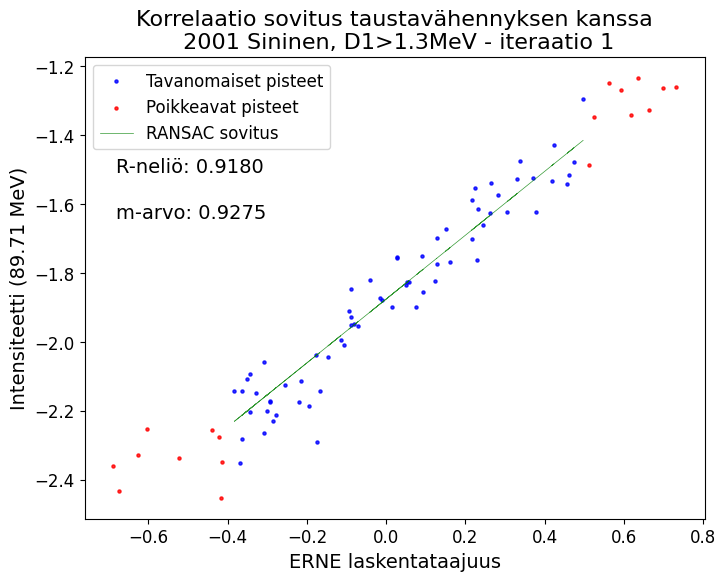

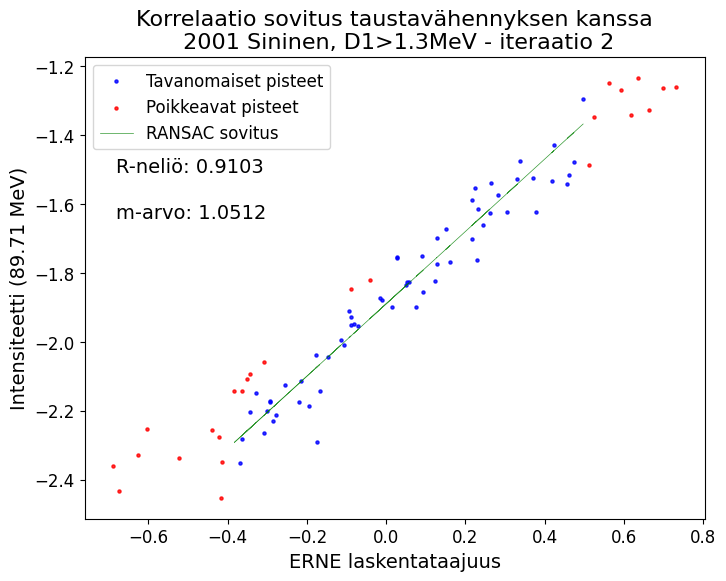

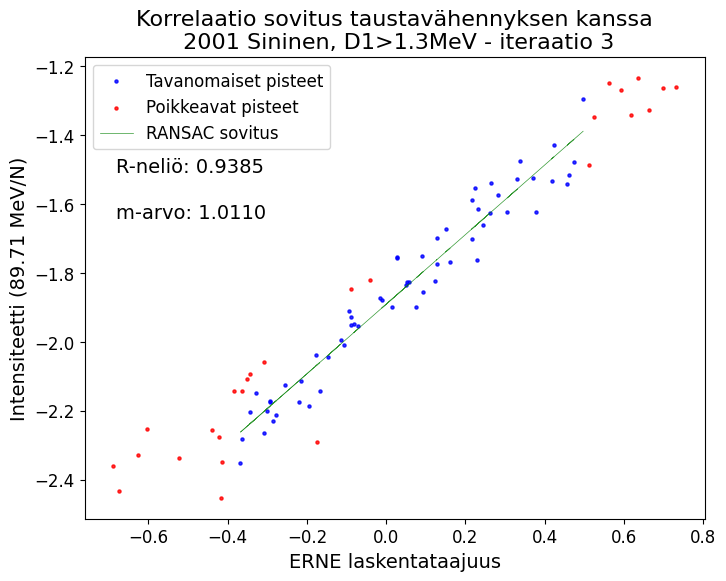

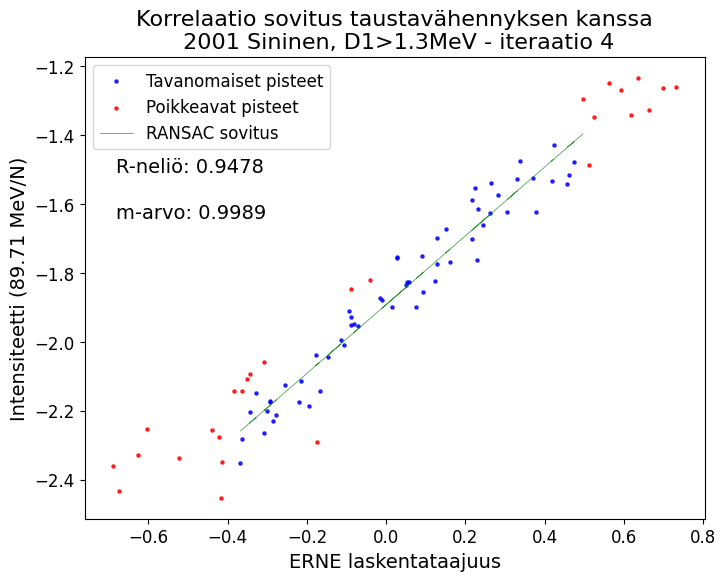

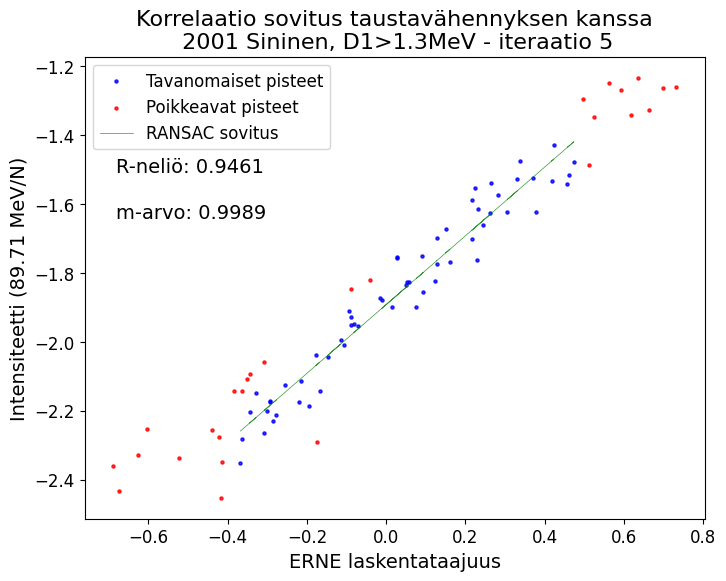

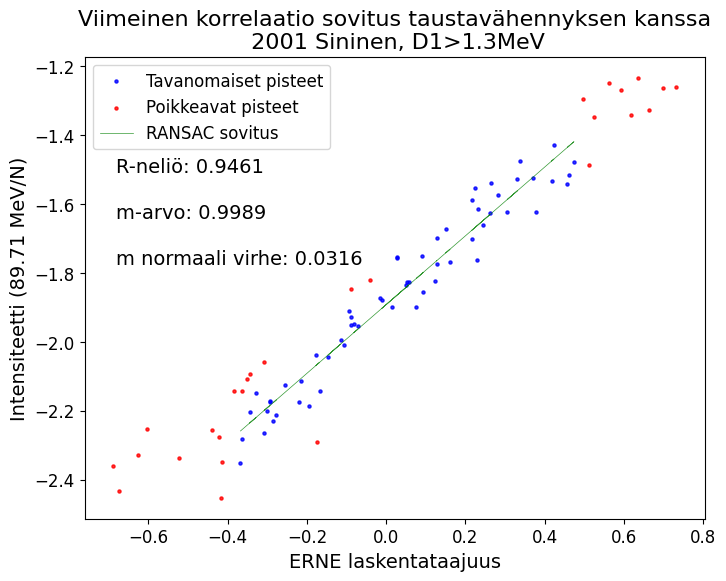

R-squared: 0.94610440891911
m value: 0.998866497128811
Standard Error of m: 0.03157745357949893


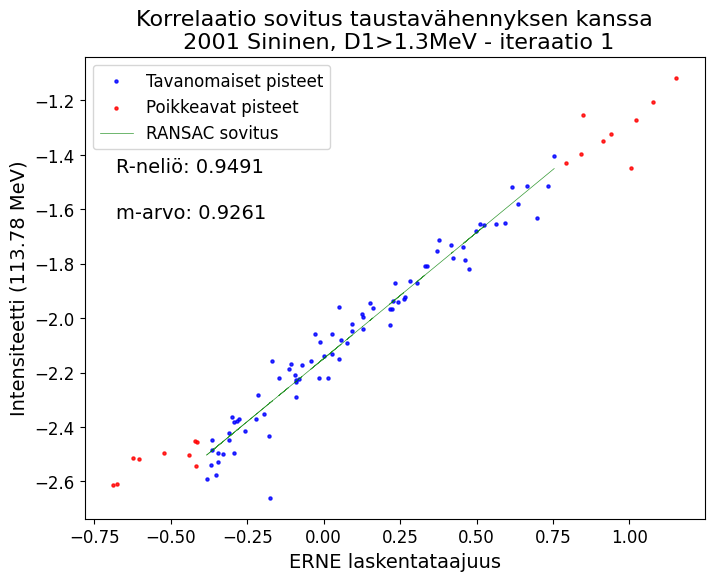

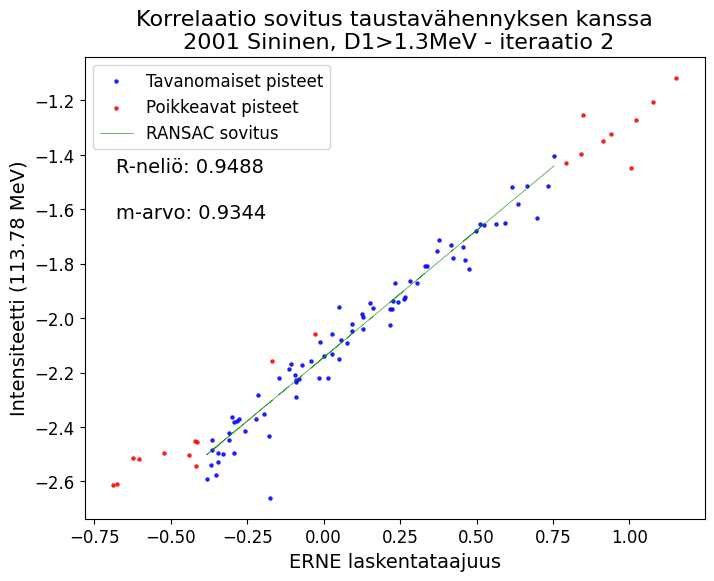

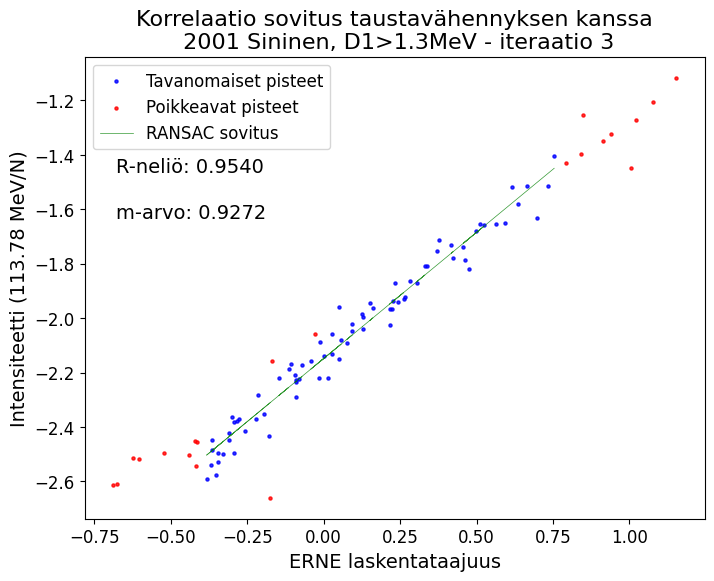

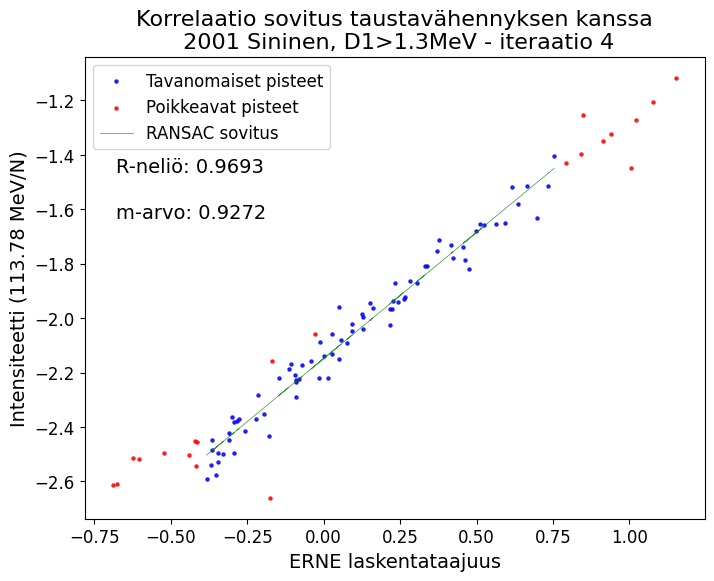

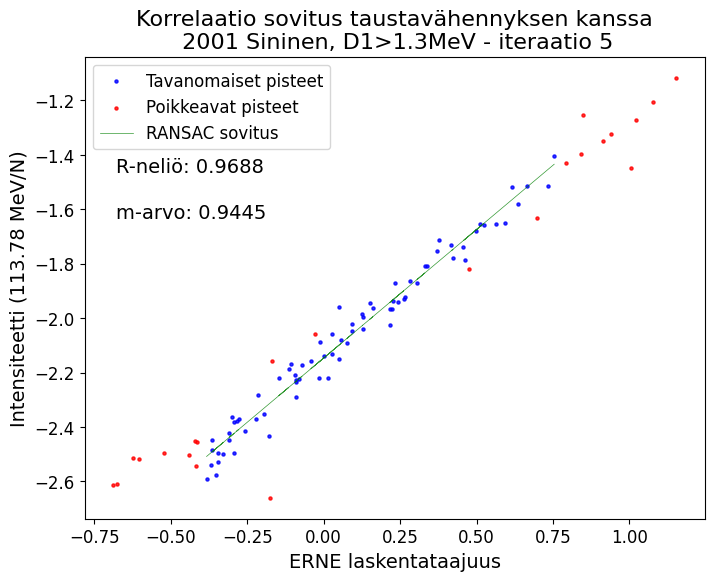

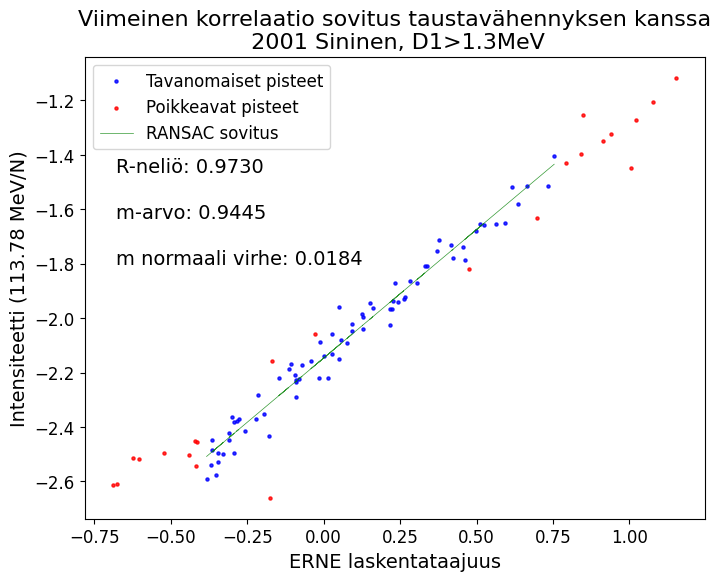

R-squared: 0.9730307745319159
m value: 0.9444905474523408
Standard Error of m: 0.018403784309524707


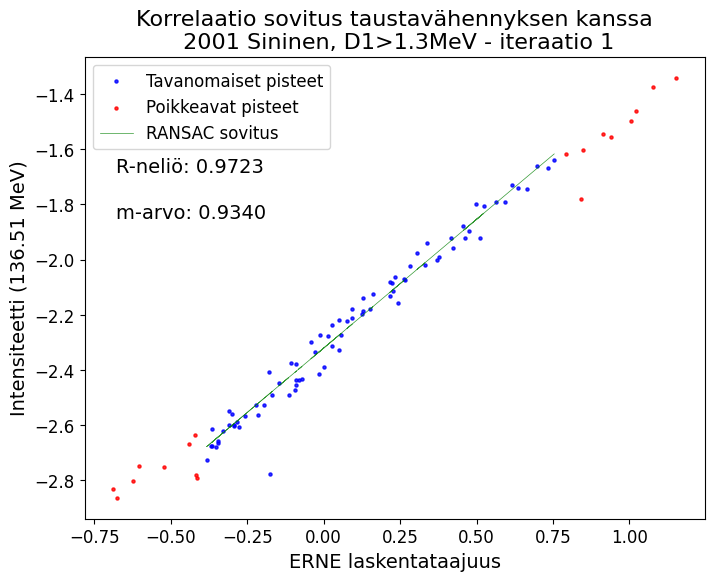

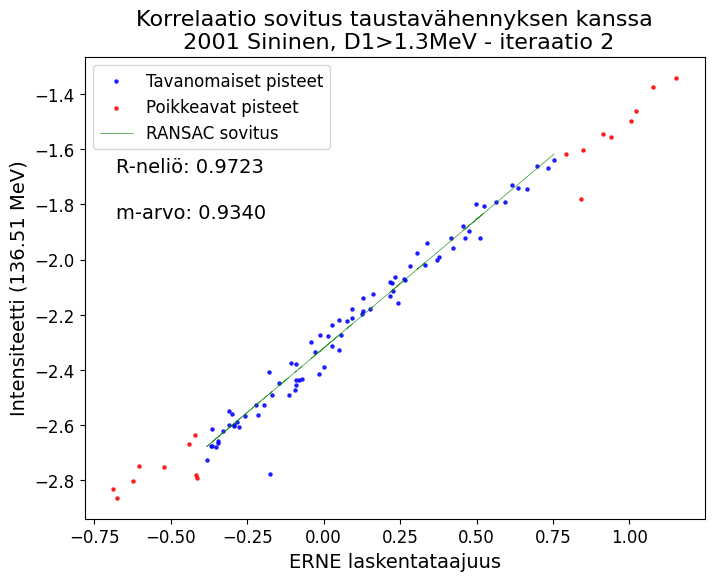

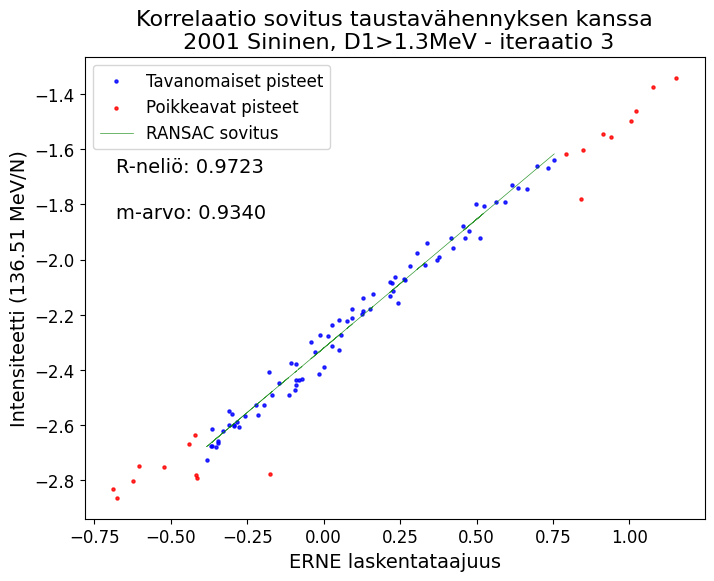

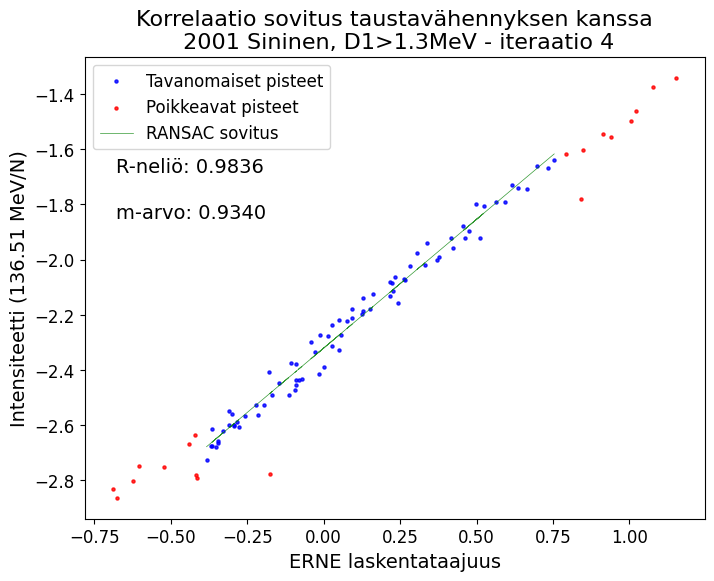

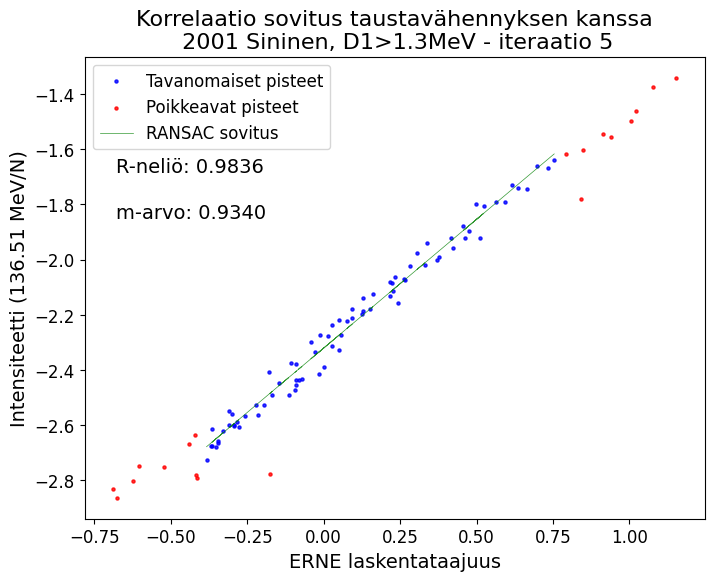

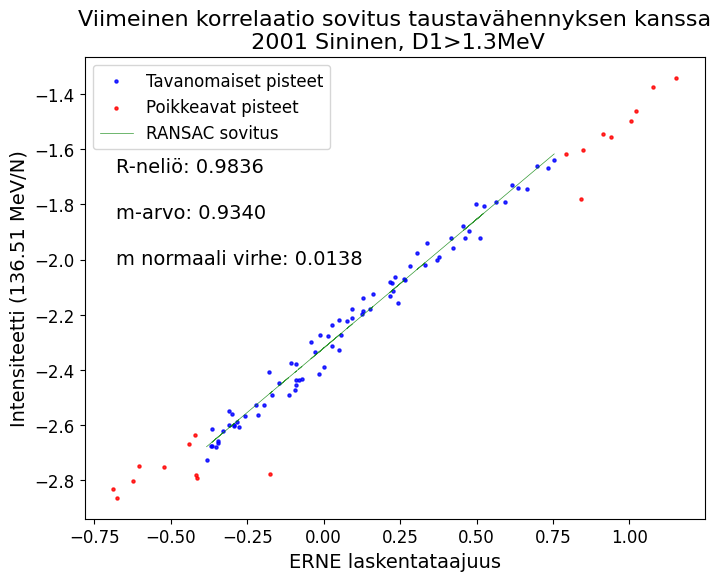

R-squared: 0.9835801219179641
m value: 0.9339692922612978
Standard Error of m: 0.013752046347360585


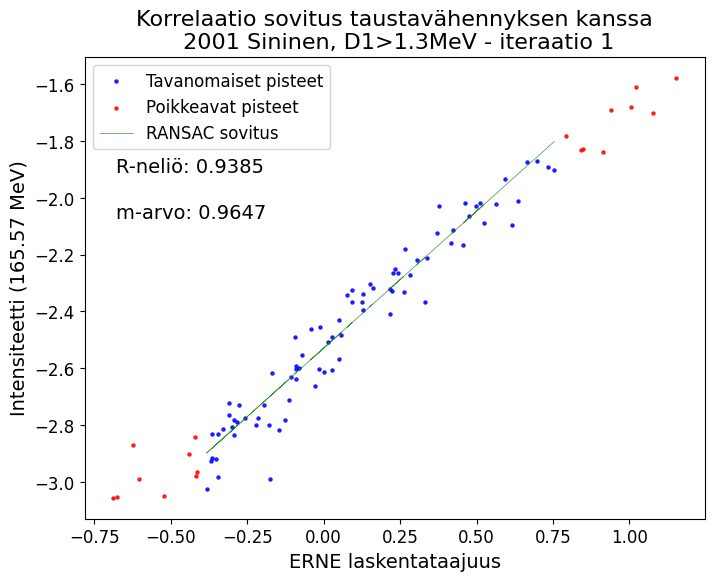

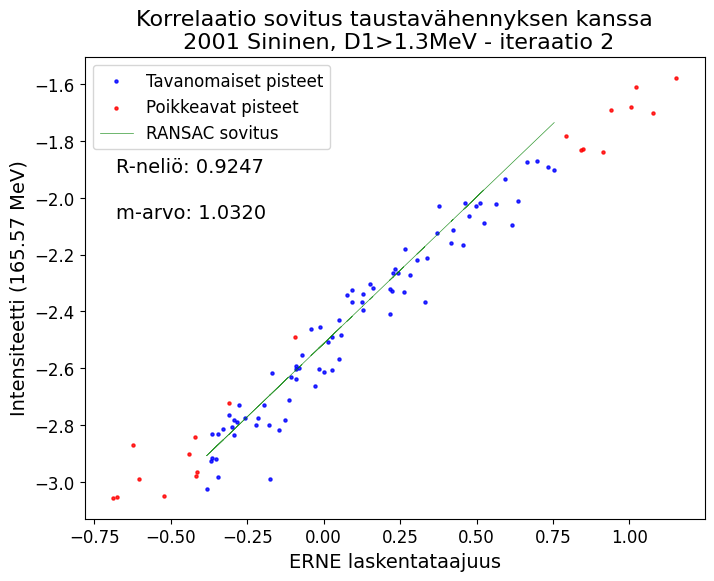

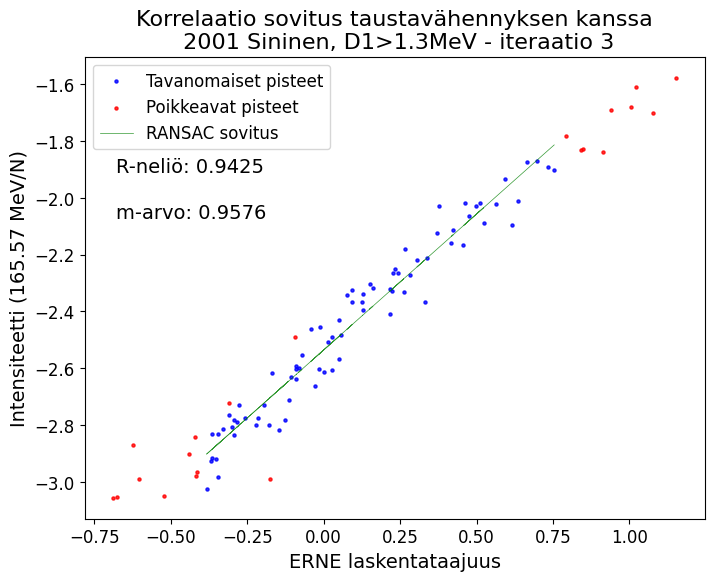

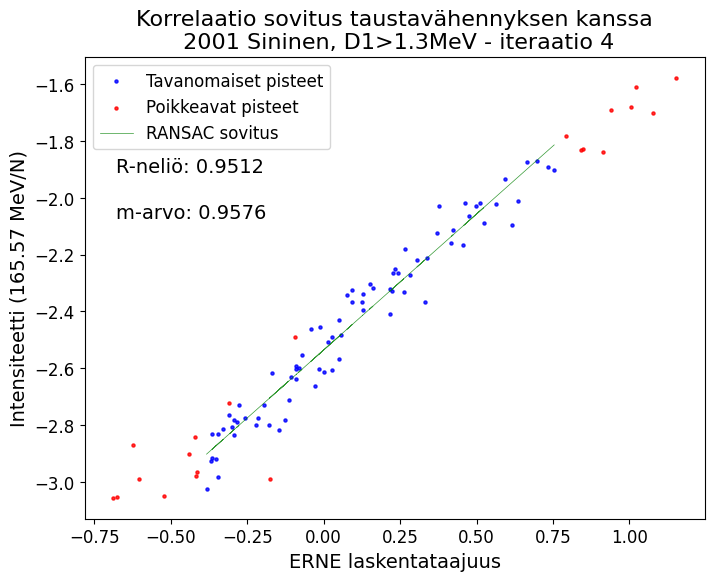

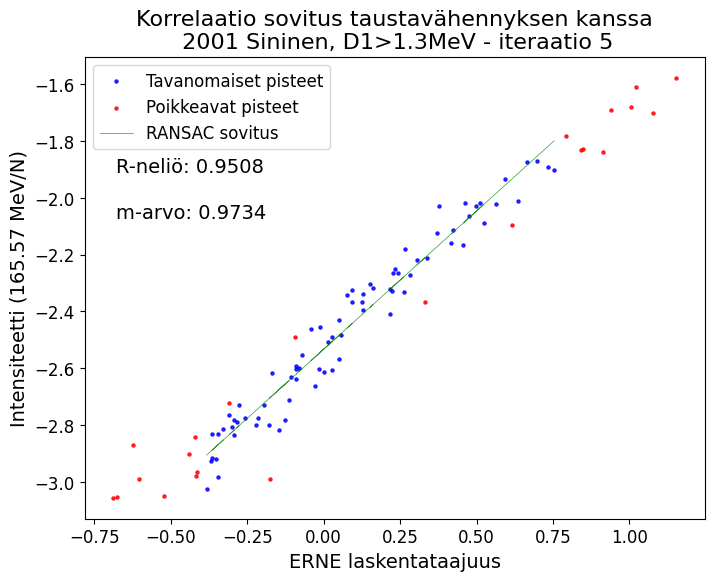

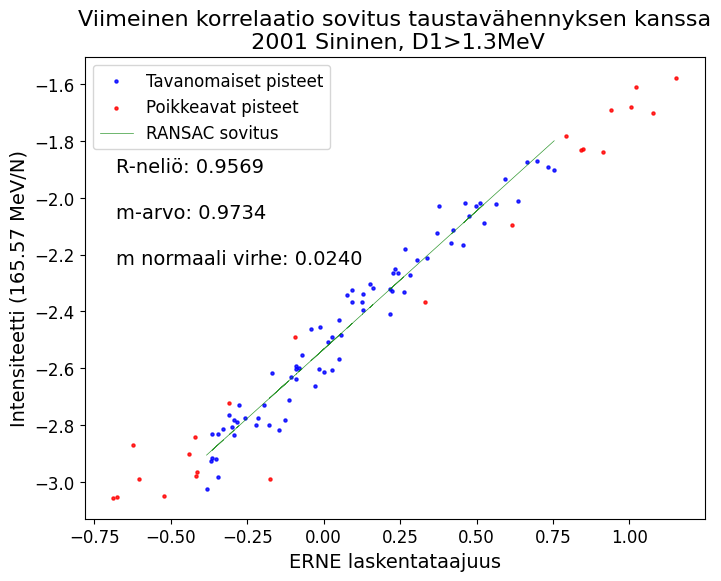

R-squared: 0.9568875203110176
m value: 0.9734414614015314
Standard Error of m: 0.024019559375620034


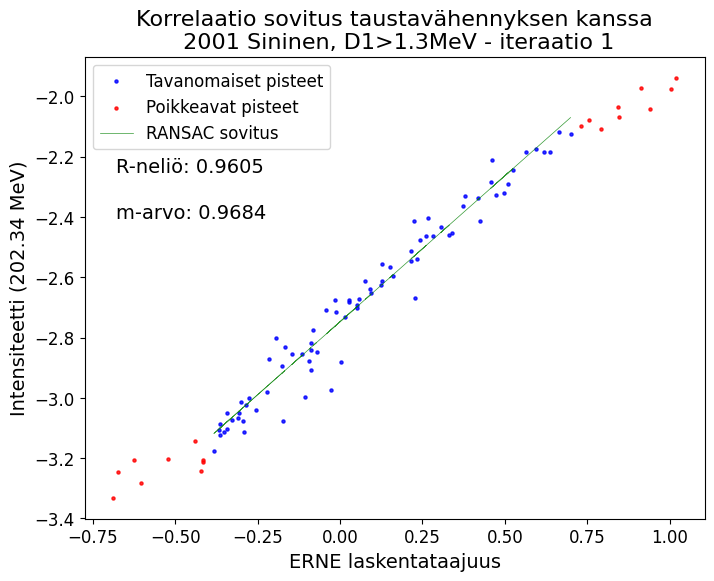

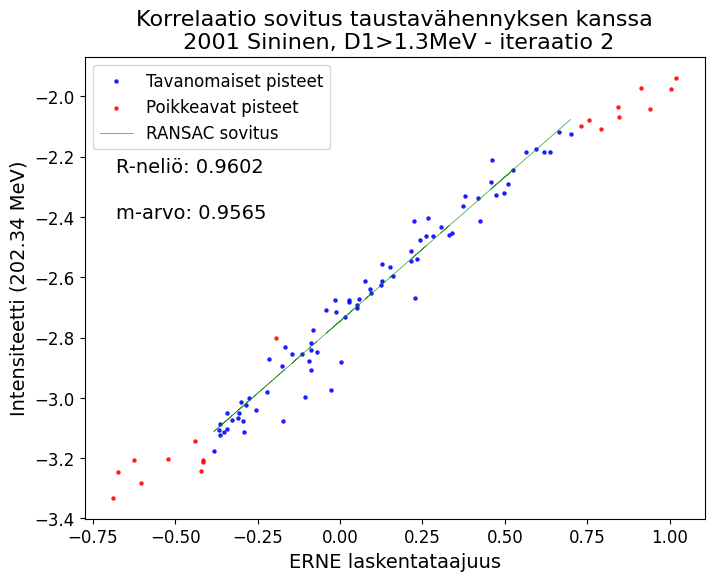

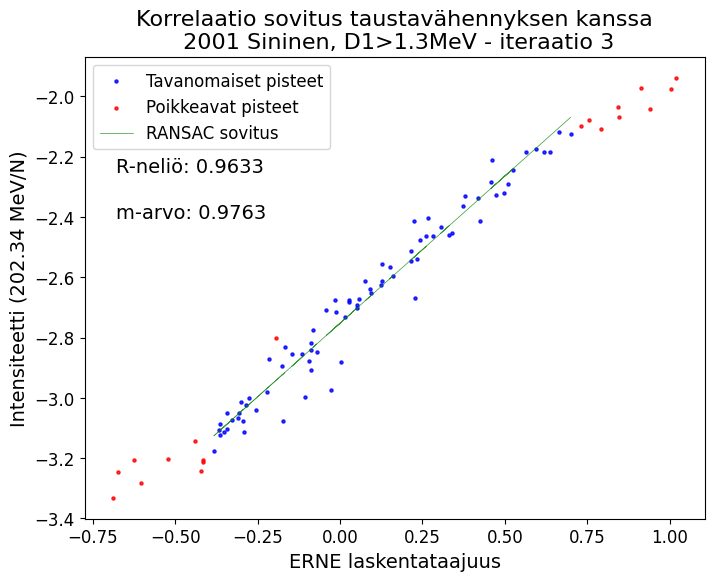

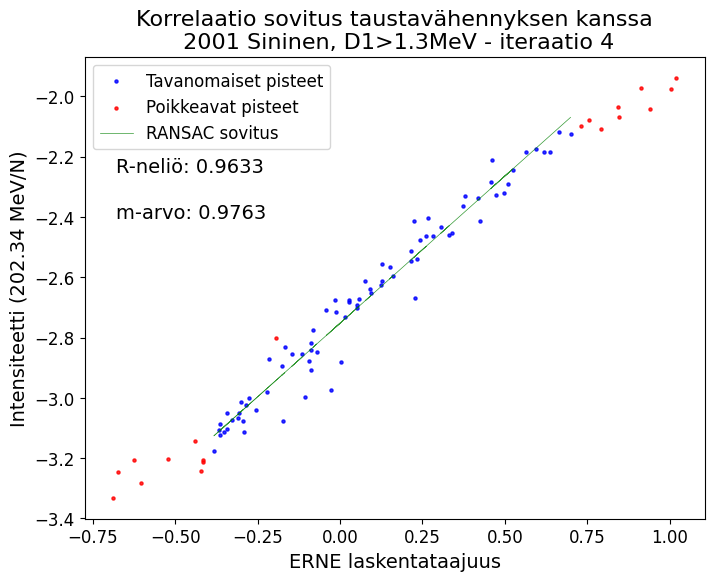

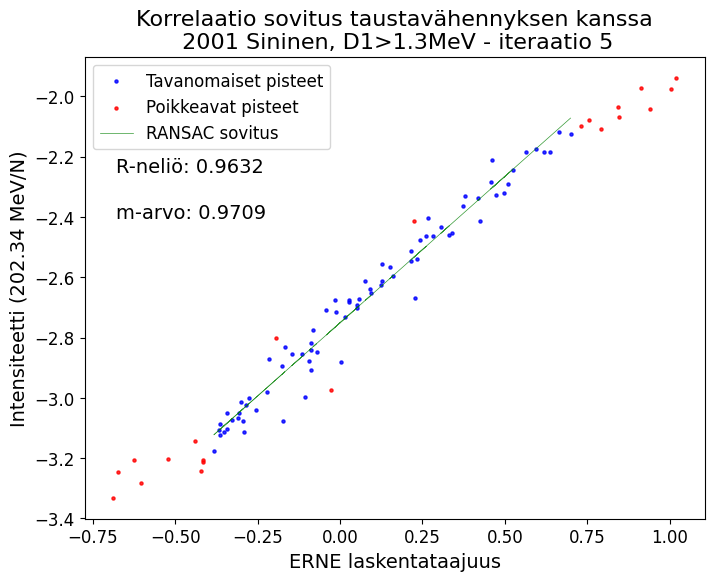

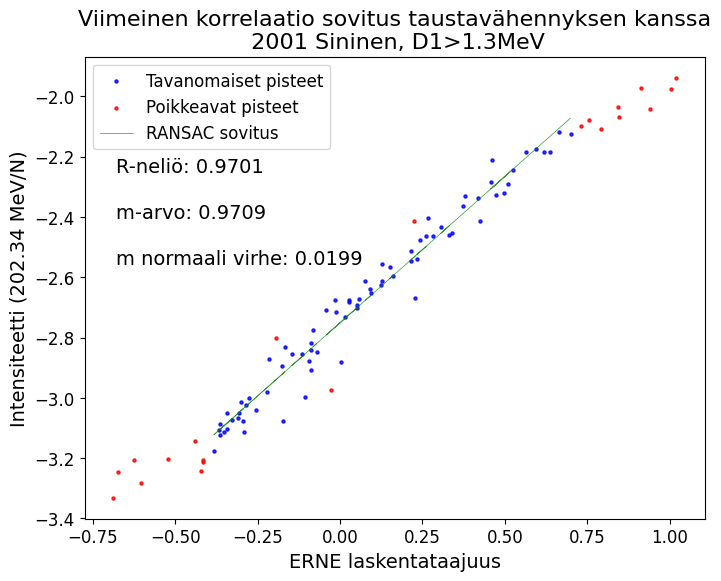

R-squared: 0.9701332087240007
m value: 0.9709325683571847
Standard Error of m: 0.019939131464988366


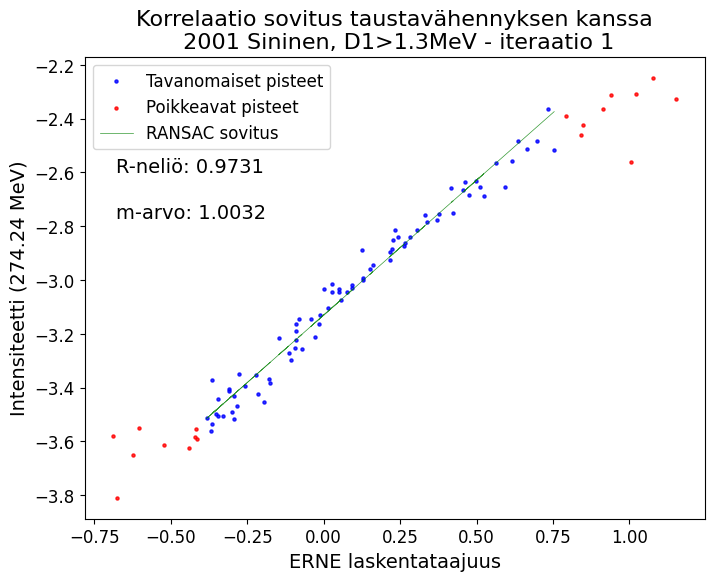

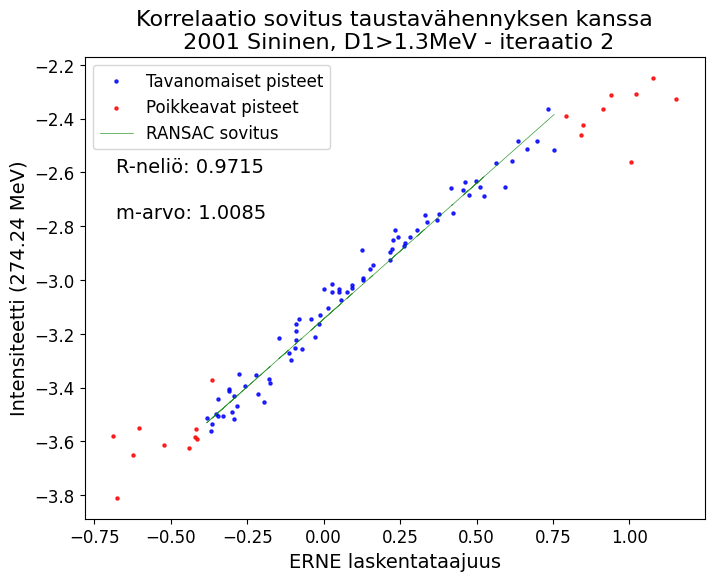

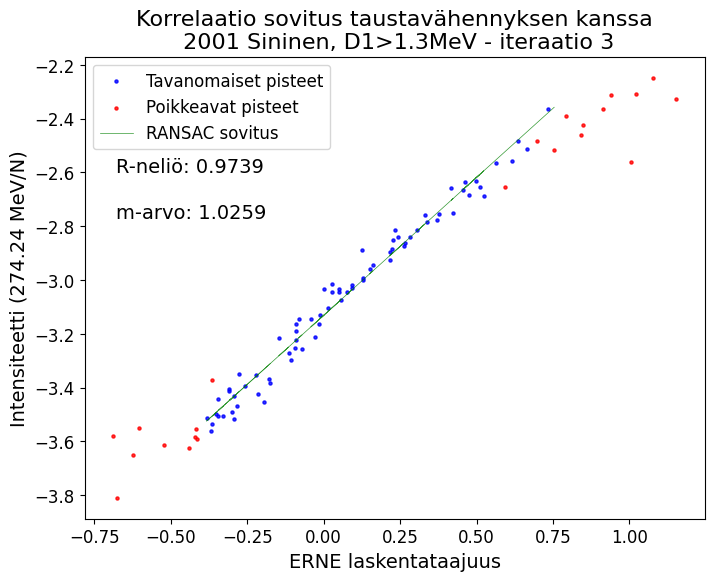

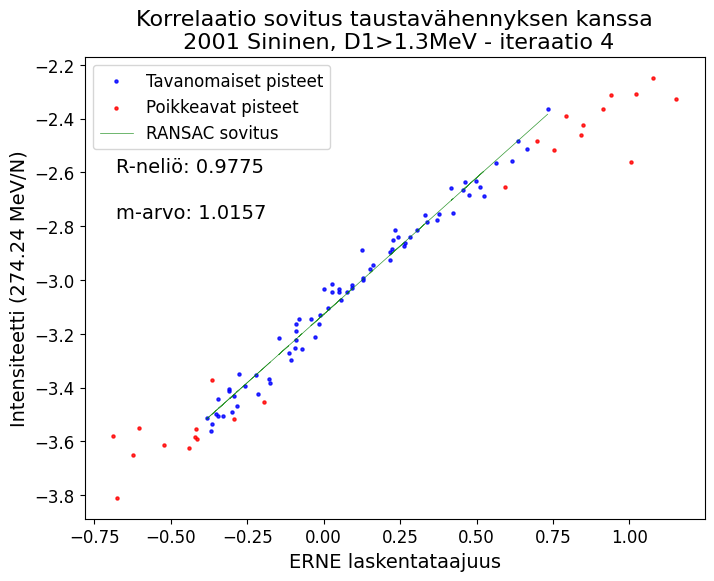

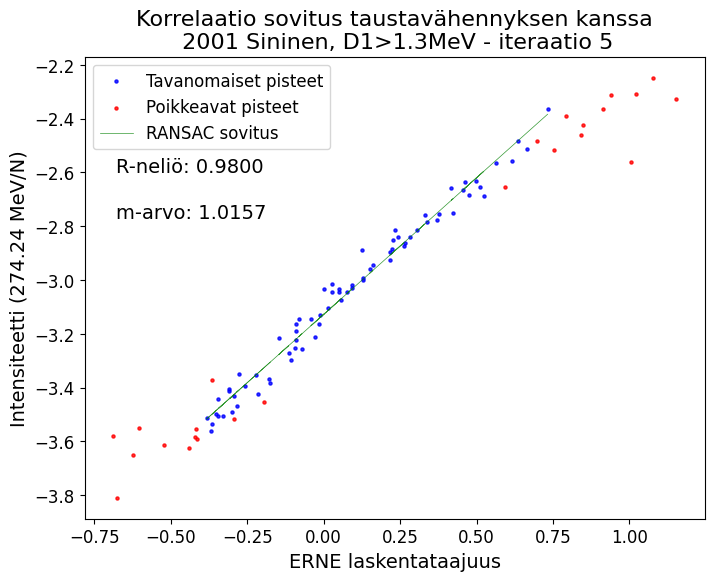

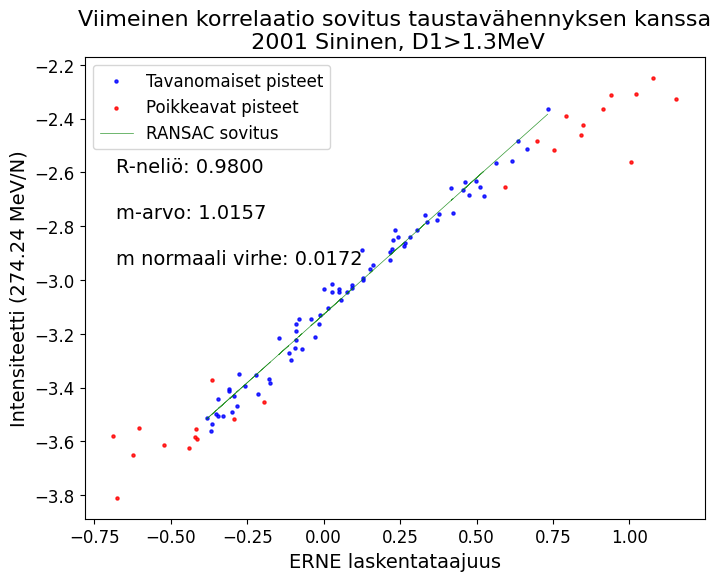

R-squared: 0.9799978889961238
m value: 1.0156848139511165
Standard Error of m: 0.017220871703640932


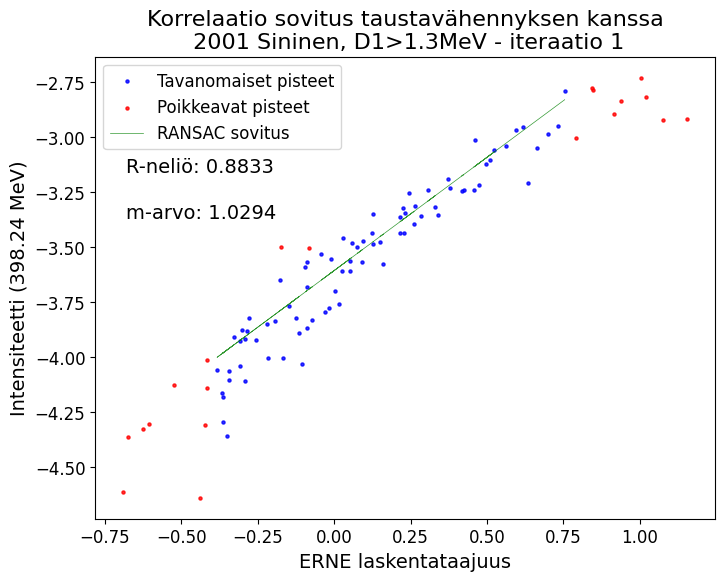

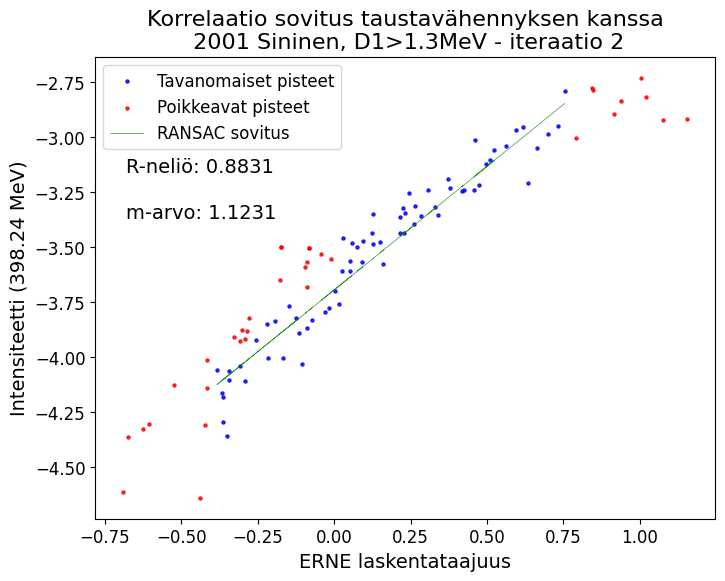

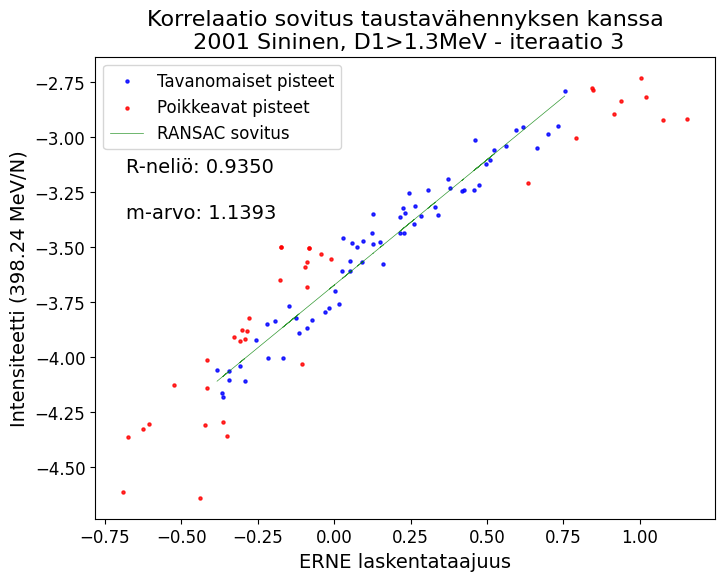

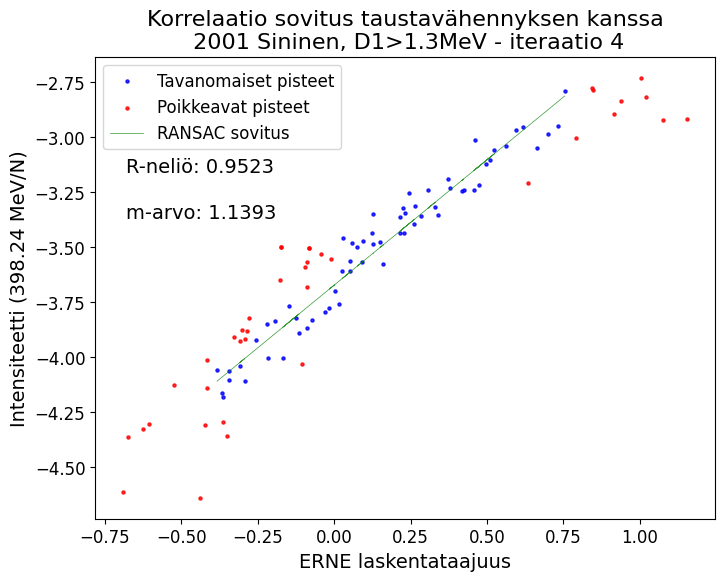

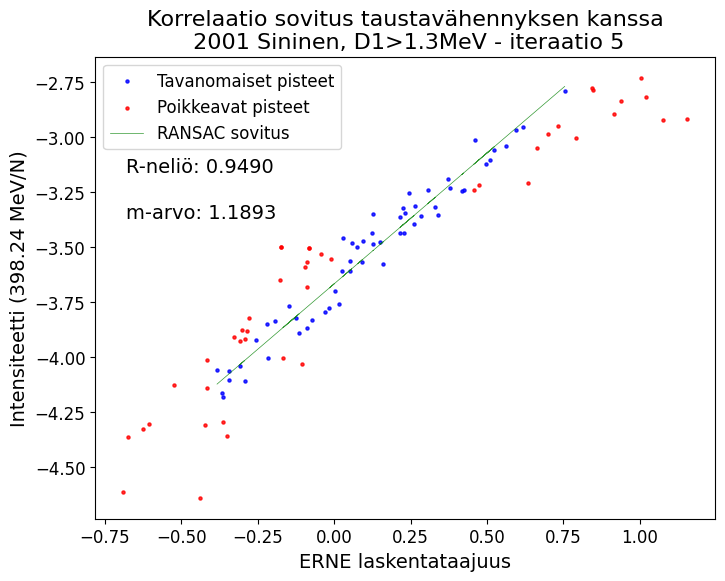

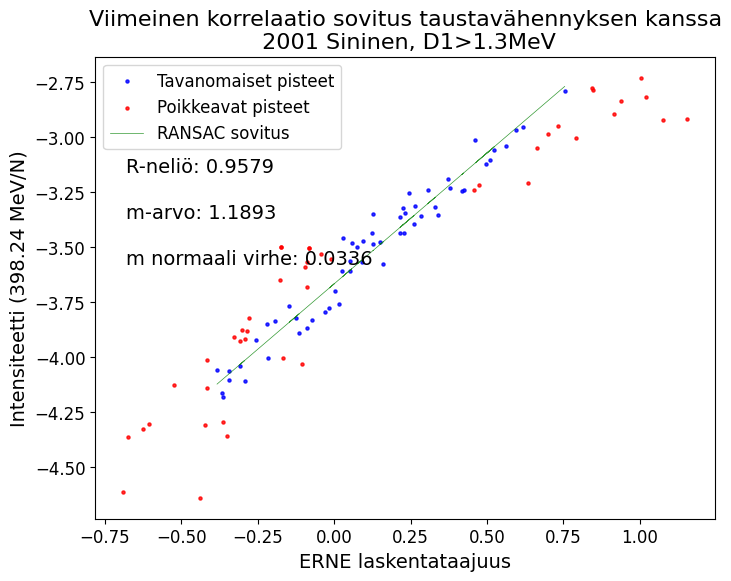

R-squared: 0.95790103454688
m value: 1.189323209652972
Standard Error of m: 0.03361970823167718


In [12]:
np.random.seed(41)

# Initialize lists to store final inliers and outliers for all iterations
final_remaining_x = []
final_remaining_y = []
final_outlier_x = []
final_outlier_y = []

# Loop over each column from 22 to 28 for correlation analysis
for i in range(22, 29):
    x = df3_log_filtered.iloc[:, 30].values.reshape(-1, 1)
    y = df3_log_filtered.iloc[:, i].values.reshape(-1, 1)

    # Remove points with NaN values from x and y
    mask = ~np.isnan(x).flatten() & ~np.isnan(y).flatten()
    x = x[mask]
    y = y[mask]

    # Identify top right and bottom left 9 points as outliers
    sorted_indices = np.argsort(x.flatten())
    top_right_indices = sorted_indices[-9:]  # Top right
    bottom_left_indices = sorted_indices[:9]  # Bottom left

    initial_outlier_mask = np.zeros_like(x, dtype=bool).flatten()
    initial_outlier_mask[top_right_indices] = True
    initial_outlier_mask[bottom_left_indices] = True

    all_outlier_x = x[initial_outlier_mask].flatten().tolist()
    all_outlier_y = y[initial_outlier_mask].flatten().tolist()

    # First 2 iterations with specific outlier removal conditions
    residual_threshold = 0.15
    for iteration in range(2):
        # Remove the initial outliers before fitting RANSAC
        x_filtered = x[~initial_outlier_mask].reshape(-1, 1)
        y_filtered = y[~initial_outlier_mask].reshape(-1, 1)
        
        ransac = RANSACRegressor(residual_threshold=residual_threshold)
        ransac.fit(x_filtered, y_filtered)

        # Get predictions and residuals
        y_pred = ransac.predict(x_filtered)
        residuals = y_filtered - y_pred

        # Determine outliers above the fit line, beyond residual threshold, and with x < 0
        residuals_flat = residuals.flatten()
        x_flat = x_filtered.flatten()
        above_fit_outlier_mask = (residuals_flat > 0) & (residuals_flat > residual_threshold) & (x_flat < 0)

        # Add the new outliers to the list
        all_outlier_x.extend(x_flat[above_fit_outlier_mask].tolist())
        all_outlier_y.extend(y_filtered.flatten()[above_fit_outlier_mask].tolist())

        # Plot current iteration with outliers
        plt.figure(figsize=(8, 6))
        plt.scatter(x_filtered[~above_fit_outlier_mask], y_filtered.flatten()[~above_fit_outlier_mask], color='blue', label='Tavanomaiset pisteet', alpha=0.8, s=5)
        plt.scatter(all_outlier_x, all_outlier_y, color='red', label='Poikkeavat pisteet', alpha=0.8, s=5)
        plt.plot(x_flat, ransac.predict(x_filtered), color='green', label='RANSAC sovitus', alpha=0.8, linewidth=0.5)
        plt.xlabel('ERNE laskentataajuus',  fontsize=14)
        plt.ylabel(f'Intensiteetti ({df3_log_filtered.columns[i]} MeV)',  fontsize=14)
        plt.title(f'Korrelaatio sovitus taustavähennyksen kanssa\n 2001 Sininen, D1>1.3MeV - iteraatio {iteration+1}',  fontsize=16)
        plt.tick_params(axis='both', which='major', labelsize=12)
        plt.legend(fontsize=12)
        plt.text(0.05, 0.75, f'R-neliö: {ransac.score(x_filtered, y_filtered):.4f}', transform=plt.gca().transAxes, fontsize=14)
        plt.text(0.05, 0.65, f'm-arvo: {ransac.estimator_.coef_[0][0]:.4f}', transform=plt.gca().transAxes, fontsize=14)

        # Save the plot to a file
        # plt.savefig(f'iteration_{i}_step_{iteration+1}.png', format='png', dpi=300, bbox_inches='tight')

        plt.show()

        # Update x and y for the next iteration with inliers
        x_filtered = x_filtered[~above_fit_outlier_mask].reshape(-1, 1)
        y_filtered = y_filtered.flatten()[~above_fit_outlier_mask].reshape(-1, 1)

        # Decrease threshold for subsequent iterations
        residual_threshold -= 0.05

    # Filter remaining inliers for subsequent iterations
    remaining_x = x_filtered
    remaining_y = y_filtered

    # Next 3 iterations using remaining points from first two iterations
    residual_threshold_2 = 0.25
    for iteration in range(3):
        ransac = RANSACRegressor(residual_threshold=residual_threshold_2)
        ransac.fit(remaining_x, remaining_y)

        # Get inlier mask from RANSAC
        inlier_mask = ransac.inlier_mask_
        outlier_mask = ~inlier_mask

        # Add new outliers to the list
        all_outlier_x.extend(remaining_x[outlier_mask].flatten().tolist())
        all_outlier_y.extend(remaining_y[outlier_mask].flatten().tolist())

        # Plot current iteration with outliers
        plt.figure(figsize=(8, 6))
        plt.scatter(remaining_x[inlier_mask], remaining_y[inlier_mask], color='blue', label='Tavanomaiset pisteet', alpha=0.8, s=5)
        plt.scatter(all_outlier_x, all_outlier_y, color='red', label='Poikkeavat pisteet', alpha=0.8, s=5)
        plt.plot(remaining_x, ransac.predict(remaining_x), color='green', label='RANSAC sovitus', alpha=0.8, linewidth=0.5)
        plt.xlabel('ERNE laskentataajuus',  fontsize=14)
        plt.ylabel(f'Intensiteetti ({df3_log_filtered.columns[i]} MeV/N)',  fontsize=14)
        plt.title(f'Korrelaatio sovitus taustavähennyksen kanssa\n 2001 Sininen, D1>1.3MeV - iteraatio {iteration+3}',  fontsize=16)
        plt.tick_params(axis='both', which='major', labelsize=12)
        plt.legend(fontsize=12)
        plt.text(0.05, 0.75, f'R-neliö: {ransac.score(remaining_x, remaining_y):.4f}', transform=plt.gca().transAxes, fontsize=14)
        plt.text(0.05, 0.65, f'm-arvo: {ransac.estimator_.coef_[0][0]:.4f}', transform=plt.gca().transAxes, fontsize=14)

        # Save the plot to a file
        # plt.savefig(f'iteration_{i}_step_{iteration+3}.png', format='png', dpi=300, bbox_inches='tight')

        plt.show()

        # Update remaining points with inliers for the next iteration
        remaining_x = remaining_x[inlier_mask].reshape(-1, 1)
        remaining_y = remaining_y[inlier_mask].reshape(-1, 1)

        # Decrease threshold for subsequent iterations
        residual_threshold_2 -= 0.05

    # Store the final inliers and outliers after all iterations
    final_remaining_x.append(remaining_x)
    final_remaining_y.append(remaining_y)
    final_outlier_x.append(all_outlier_x)
    final_outlier_y.append(all_outlier_y)
    
    ### NEW SECTION ###    
    X_with_const = sm.add_constant(remaining_x)  # Add intercept term
    model = sm.OLS(remaining_y, X_with_const).fit()
    
    # Extract slope and its standard error
    m_value = model.params[1]
    m_value_se = model.bse[1]
    ### END OF NEW SECTION ###

    # Final plot with accumulated inliers and outliers
    plt.figure(figsize=(8, 6))
    plt.scatter(remaining_x.flatten(), remaining_y.flatten(), color='blue', label='Tavanomaiset pisteet', alpha=0.8, s=5)
    plt.scatter(all_outlier_x, all_outlier_y, color='red', label='Poikkeavat pisteet', alpha=0.8, s=5)
    plt.plot(remaining_x, ransac.predict(remaining_x), color='green', label='RANSAC sovitus', alpha=0.8, linewidth=0.5)
    plt.xlabel('ERNE laskentataajuus',  fontsize=14)
    plt.ylabel(f'Intensiteetti ({df3_log_filtered.columns[i]} MeV/N)',  fontsize=14)
    plt.title('Viimeinen korrelaatio sovitus taustavähennyksen kanssa\n 2001 Sininen, D1>1.3MeV',  fontsize=16)
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.legend(fontsize=12)
    plt.text(0.05, 0.75, f'R-neliö: {ransac.score(remaining_x, remaining_y):.4f}', transform=plt.gca().transAxes, fontsize=14)
    plt.text(0.05, 0.65, f'm-arvo: {m_value:.4f}', transform=plt.gca().transAxes, fontsize=14)
    plt.text(0.05, 0.55, f'm normaali virhe: {m_value_se:.4f}', transform=plt.gca().transAxes, fontsize=14)

    # Save the final plot
    #plt.savefig(f'final_iteration_{i}.png', format='png', dpi=300, bbox_inches='tight')

    plt.show()

    # Print final R-squared, m-value, and its standard error
    print(f'R-squared: {ransac.score(remaining_x, remaining_y)}')
    print(f'm value: {m_value}')
    print(f'Standard Error of m: {m_value_se}')

---

## Plotting Outliers and Inliers

The following code demonstrates how to visualize outliers and inliers in the dataset.

- We iterate over `final_remaining_x`, which contains sets of values corresponding to identified inliers.
- For each set, we find the indices in `log_AC1` where values match and store them in `matching_indices_sets`.
- These indices are later used to distinguish inliers from outliers in the plots.

Each selected energy column is plotted separately:
- Inliers (values in `matching_indices_sets`) are plotted in <font color='blue'>blue</font>.
- Outliers (all other values) are plotted in <font color='red'>red</font>.

To improve readability, we dynamically adjust the x-axis labels:
- `AutoDateLocator()` automatically determines appropriate tick intervals based on the date range, preventing label overlap.
- `DateFormatter('%Y-%m-%d')` ensures that x-axis labels follow a consistent `YYYY-MM-DD` format.


In [13]:
sub_df = pd.concat([data_2001.iloc[1104:1206]]) 

# Convert the column to numeric, coercing errors to NaN
sub_df["AC1_numeric"] = pd.to_numeric(sub_df["AC1 (D1>1.3MeV)"], errors='coerce')

# Filter out non-positive values to avoid log10 of invalid data
sub_df_filtered = sub_df[sub_df["AC1_numeric"] > 0].copy()

# Apply log10 safely to the filtered data using .loc to avoid the SettingWithCopyWarning
sub_df_filtered.loc[:, "log_AC1"] = np.log10(sub_df_filtered["AC1_numeric"])

# Initialize a list to store the matching indices for each set in final_remaining_x
matching_indices_sets = []

# Iterate over each set of values in final_remaining_x
for x_set in final_remaining_x:
    # Initialize a list to store the indices where values match for the current set
    matching_indices = []
    
    # Iterate over each value in the current set of final_remaining_x
    for val in x_set.flatten():
        # Find indices where the value matches in log_AC1
        indices = sub_df_filtered.index[sub_df_filtered["log_AC1"] == val].tolist()
        matching_indices.extend(indices)
    
    # Add the matching indices for the current set to the list
    matching_indices_sets.append(matching_indices)

# Display the matching indices for each set
#for i, indices in enumerate(matching_indices_sets):
#    print(f"Matching indices for set {i+1}: {indices}")

In [14]:
# Define the date range "2001-04-16 00:00:00", "2001-04-18 02:30:00"
start_date = '2001-04-16 00:00:00'
end_date = '2001-04-18 02:30:00'

# Filter the dataframe based on the date range
mask = (imp8_df_00['date_time'] >= start_date) & (imp8_df_00['date_time'] <= end_date)
filtered_df = imp8_df_00.loc[mask].copy()

# Adjust the index to start from
filtered_df.index = range(1104, 1104 + len(filtered_df))

#print(filtered_df)

<div class="alert alert-block alert-info">
<b>Note:</b> Some print statements are commented out to reduce output clutter.  
If you wish to inspect intermediate results, remove the `#` before the print statements and rerun the code. 
</div>

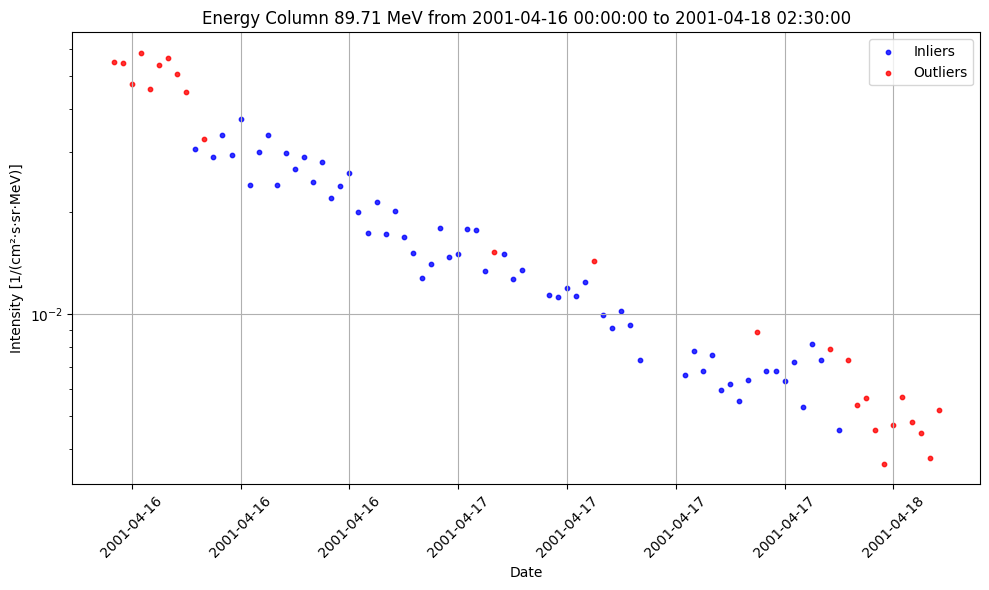

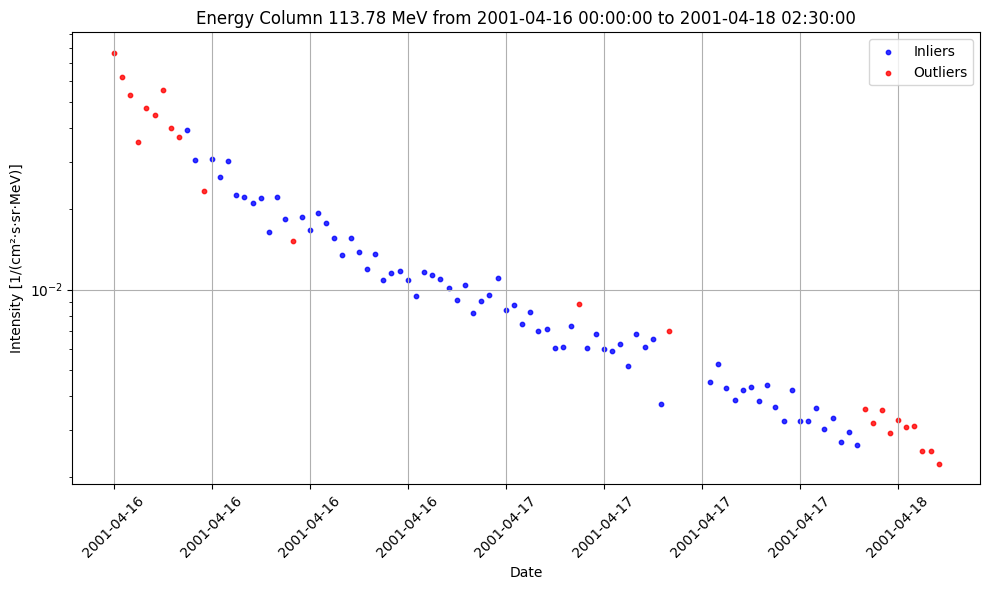

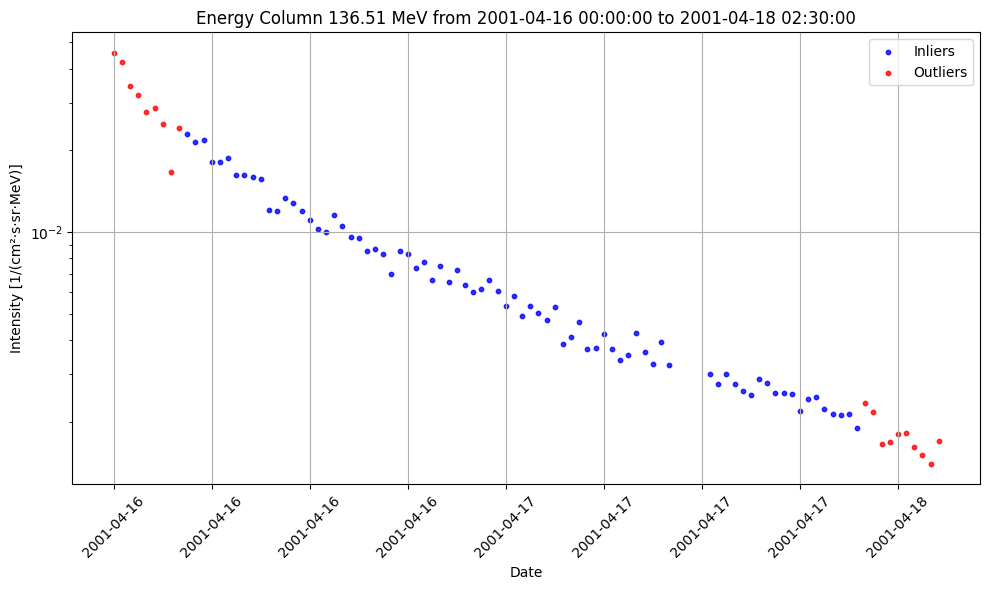

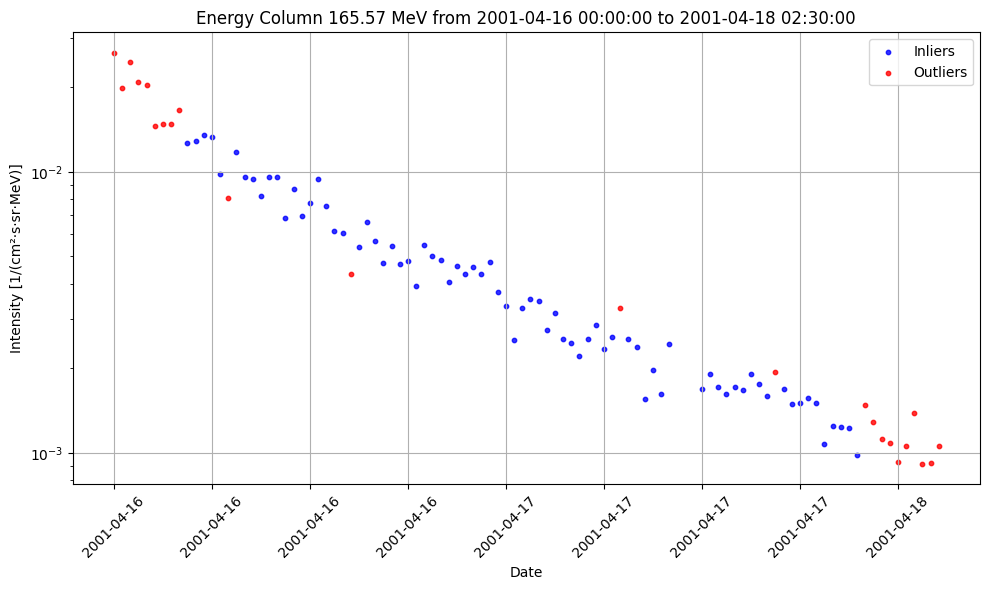

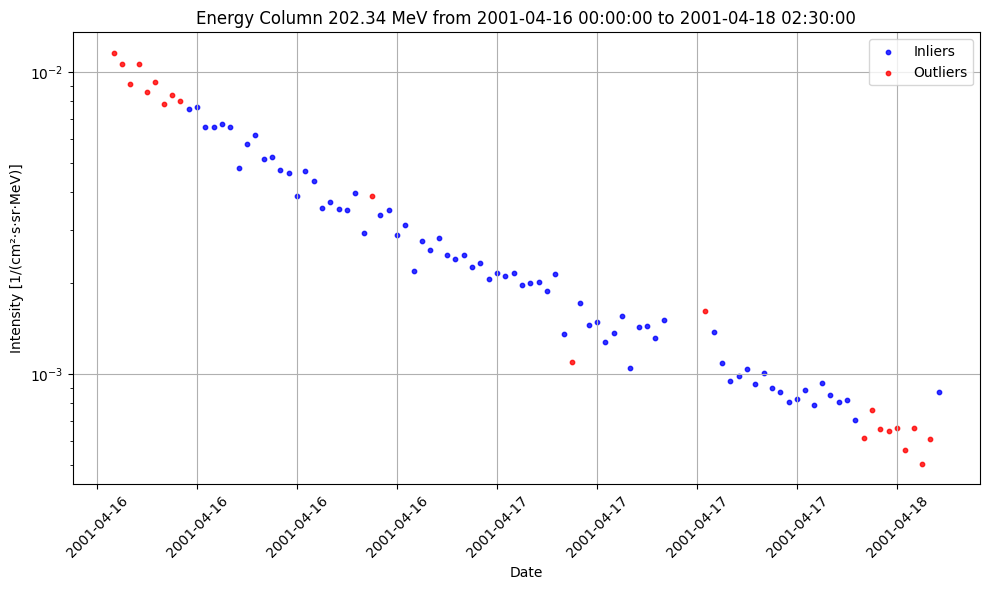

In [15]:
columns_to_plot = filtered_df.columns[24:29]

# Ensure date_time is a proper datetime object
filtered_df['date_time'] = pd.to_datetime(filtered_df['date_time'])

# Plotting each column in a separate graph
for i, column in enumerate(columns_to_plot):
    plt.figure(figsize=(10, 6))
    
    # Access the matching indices for the current scatter plot, if available
    if i < len(matching_indices_sets):
        blue_indices = matching_indices_sets[i]
    else:
        blue_indices = []  # Handle case where matching_indices_sets has fewer sets than columns_to_plot
    
    # Separate the indices for blue and red points
    blue_mask = filtered_df.index.isin(blue_indices)
    red_mask = ~blue_mask
    
    # Plot blue points
    plt.scatter(filtered_df['date_time'][blue_mask], filtered_df[column][blue_mask], color='blue', s=10, label='Inliers', alpha=0.8)
    
    # Plot red points
    plt.scatter(filtered_df['date_time'][red_mask], filtered_df[column][red_mask], color='red', s=10, label='Outliers', alpha=0.8)
    
    # Set title and labels
    plt.title('Energy Column {} MeV from {} to {}'.format(column, start_date, end_date))
    plt.xlabel('Date')
    plt.ylabel('Intensity [1/(cm²·s·sr·MeV)]')
    plt.yscale('log')

    # Customize x-axis tick frequency
    locator = AutoDateLocator()  # or MaxNLocator for numeric axis
    plt.gca().xaxis.set_major_locator(locator)
    plt.gca().xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))
    
    # Grid, legend, and other plot settings
    plt.grid(True)
    plt.legend(loc='upper right')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

---

## Intensity as a Function of Energy

In this section, we analyze the intensity as a function of energy using data from the first few rows of the subset `df_first_x`

**Steps**:
1. **Extract Intensity Values**
- Select rows from `df_slice` ie. the `event` to create `df_first_x`.
- Retrieve intensity values corresponding to specific energy levels.
  
2. **Handle Invalid Data**
- Replace non-positive intensity values with `NaN` to exclude them from analysis.

3. **Plot Intensity Data with Error Bars**
- Display valid intensity points as a scatter plot.
- Apply error bars based on predefined `energy_ranges`.

4. **Fit a Power-Law Model in Log-Log Space**
- Perform a log-log fit using `np.polyfit()`.
- Overlay the fitted trend line on the scatter plot.

 
The **first** example includes all available data.
The **second** example excludes outliers using `matching_indices_sets`.
The **Third** example calculates the average intensity of the inliers at each energy level 

### First Example

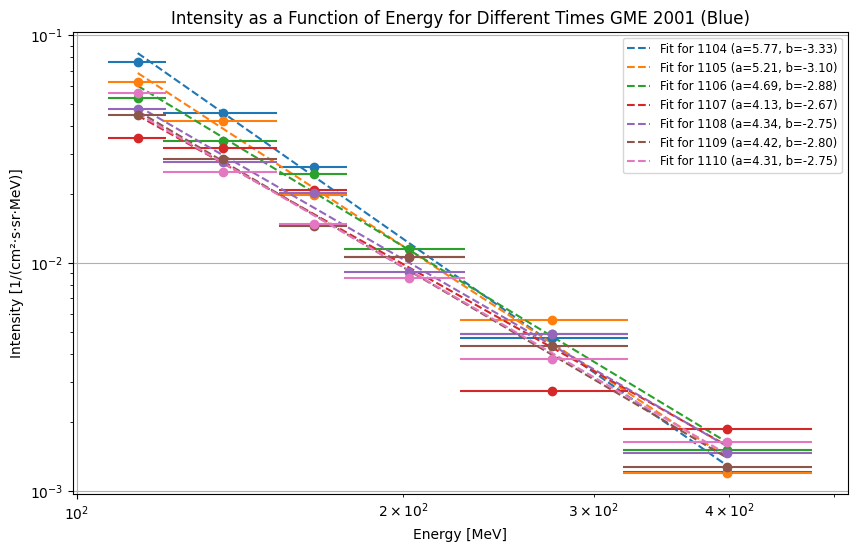

In [16]:
df_slice = pd.concat([data_2001.iloc[1104:1206]])
df_first_x = df_slice.iloc[:7]

# Extract energies and their ranges
energies = df_first_x.columns[25:31].astype(float)  # Convert to numeric values
energy_ranges = np.array([7.0, 16.5, 12.0, 26.0, 48.5, 79.0])  # Your predefined energy_ranges as an array
erne_ac1 = df_first_x.iloc[:, 32]  # Assuming erne_ac1 column is at index 32
erne_tot = df_first_x.iloc[:, 31]  # Assuming erne_tot column is at index 31

# Prepare the plot
plt.figure(figsize=(10, 6))

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Lists to store data for the matrix
times = []
a_coeffs = []
b_coeffs = []
erne_ac1_values = []
erne_tot_values = []
df_result = None # clear old

for i, (index, row) in enumerate(df_first_x.iterrows()):
    intensities = row[25:31].values.astype(float)  # Assuming energy columns are from index 24 to 30

    # Initialize lists to store valid data points
    valid_energies = []
    valid_intensities = []

    for energy, intensity in zip(energies, intensities):
        if intensity > 0:
            valid_energies.append(energy)
            valid_intensities.append(intensity)
        else:
            valid_energies.append(np.nan)  # Replace invalid intensity with NaN
            valid_intensities.append(np.nan)  # Replace invalid intensity with NaN

    # Convert lists to numpy arrays
    valid_energies = np.array(valid_energies)
    valid_intensities = np.array(valid_intensities)

    # Plot valid data points with error bars
    plt.errorbar(
        valid_energies,
        valid_intensities,
        xerr=energy_ranges,  # Use energy_ranges directly for error bars
        fmt='o',  # 'o' for dots, no connecting lines
        color=colors[i % len(colors)],  # Cycle through colors
        label=None  # No label for individual points
    )

    # Perform linear fit in log-log space for valid data points
    mask = ~np.isnan(valid_intensities)  # Mask for valid intensities (not NaN)
    if mask.any():  # Check if there are any valid data points
        log_energies = np.log10(valid_energies[mask])
        log_intensities = np.log10(valid_intensities[mask])
        coeffs = np.polyfit(log_energies, log_intensities, 1)
        fit_intensities = 10 ** np.polyval(coeffs, log_energies)

        # Plot the linear fit with the same color
        plt.plot(valid_energies[mask], fit_intensities, linestyle='--', color=colors[i % len(colors)],
                 label=f'Fit for {index} (a={coeffs[1]:.2f}, b={coeffs[0]:.2f})')

        # Store data for matrix
        times.append(index)
        a_coeffs.append(coeffs[1])
        b_coeffs.append(coeffs[0])
        erne_ac1_values.append(erne_ac1[index])
        erne_tot_values.append(erne_tot[index])

# Create DataFrame for matrix data
df_result = pd.DataFrame({
    'time': times,
    'a': a_coeffs,
    'b': b_coeffs,
    'erne ac1': erne_ac1_values,
    'erne tot': erne_tot_values
})

# Save DataFrame to CSV
#df_result.to_csv('matrix_2001_Blue_event_cleaned.csv', index=False)

# Set logarithmic scales
plt.xscale('log')
plt.yscale('log')

# Labels and title
plt.xlabel('Energy [MeV]')
plt.ylabel('Intensity [1/(cm²·s·sr·MeV)]')
plt.title('Intensity as a Function of Energy for Different Times GME 2001 (Blue)')

# Legend and grid
plt.legend(loc='upper right', fontsize='small')
plt.grid(True)

# Show plot
plt.show()

In [17]:
df_result

time         a         b   erne ac1   erne tot
0  1104  5.766844 -3.329290  14.252024  34.654770
1  1105  5.214309 -3.103049  11.904357  29.277652
2  1106  4.693741 -2.877199  10.486582  26.733999
3  1107  4.128217 -2.665412  10.086269  25.366263
4  1108  4.337092 -2.746764   8.693515  23.648254
5  1109  4.418381 -2.797368   8.205634  22.047003
6  1110  4.310083 -2.749707   7.035970  20.226831

#### Understanding `.to_csv()`
The `to_csv()` function is used to save DataFrame contents into a CSV file, which can be easily reloaded for further analysis. 

**Basic Syntax:**
```python
df_result.to_csv('output_file.csv', index=False)
```
- 'output_file.csv': Specifies the filename.
- index=False: Prevents the DataFrame index from being written to the file.

Key Benefits of .to_csv():
1. Preserves Processed Data: Allows saving results for later use without re-running computations.
2. Interoperability: CSV files can be opened in Excel, Pandas, or other data analysis tools.
3. Customizable: Supports different separators (sep=','), encodings (encoding='utf-8'), and column selections (columns=['col1', 'col2']).

<div class="alert alert-block alert-info">
<b>Note:</b> In the code exapmle below you can notice the comment "#+9", which referes to the index being moved due to outliers. 
</div>

### Second Example

In this section, we refine our intensity dataset by excluding outliers. We use `matching_indices_sets` to filter out **non-representative values**. Non-matching indices are set to `NaN` before further processing.

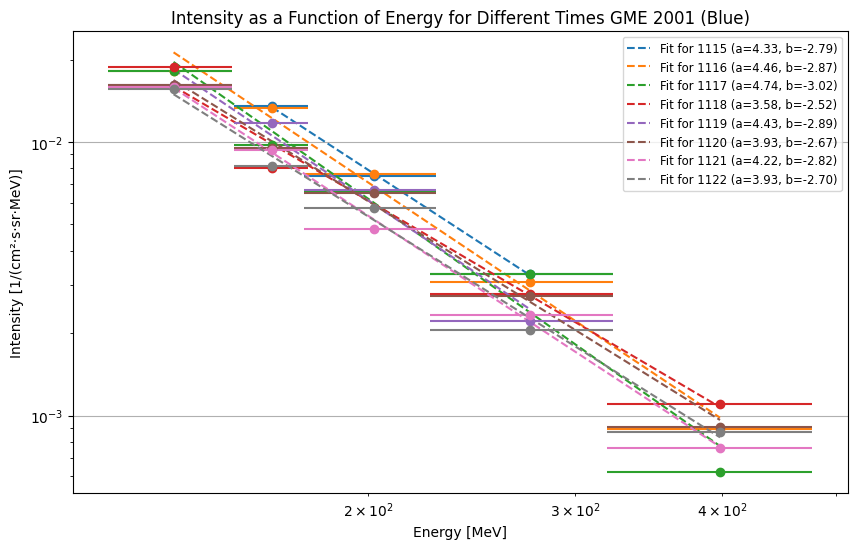

In [18]:
df_slice_NaN = pd.concat([data_2001.iloc[1115:1206]]) #+9
df_copy = df_slice_NaN.copy()

# Extract energies and their ranges
energy_columns = df_slice_NaN.columns[25:31]
energy_ranges = np.array([7.0, 16.5, 12.0, 26.0, 48.5, 79.0])  # Your predefined energy_ranges as an array
erne_ac1 = df_slice_NaN.iloc[:, 32]  # Assuming erne_ac1 column is at index 32
erne_tot = df_slice_NaN.iloc[:, 31]  # Assuming erne_tot column is at index 31

# Prepare the plot
plt.figure(figsize=(10, 6))

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Lists to store data for the matrix
times = []
a_coeffs = []
b_coeffs = []
erne_ac1_values = []
erne_tot_values = []


# Set values to NaN where the index is not in the matching indices set
for col, indices in zip(energy_columns, matching_indices_sets):
    df_copy.loc[~df_copy.index.isin(indices), col] = np.nan
    
df_first_x = df_copy.iloc[:8]

for i, (index, row) in enumerate(df_first_x.iterrows()):
    intensities = row[25:31].values.astype(float)  # Assuming energy columns are from index 24 to 30

    # Initialize lists to store valid data points
    valid_energies = []
    valid_intensities = []

    for energy, intensity in zip(energy_columns, intensities):
        if intensity > 0:
            valid_energies.append(float(energy))
            valid_intensities.append(intensity)
        else:
            valid_energies.append(np.nan)  # Replace invalid intensity with NaN
            valid_intensities.append(np.nan)  # Replace invalid intensity with NaN

    # Convert lists to numpy arrays
    valid_energies = np.array(valid_energies)
    valid_intensities = np.array(valid_intensities)

    # Plot valid data points with error bars
    plt.errorbar(
        valid_energies,
        valid_intensities,
        xerr=energy_ranges,  # Use energy_ranges directly for error bars
        fmt='o',  # 'o' for dots, no connecting lines
        color=colors[i % len(colors)],  # Cycle through colors
        label=None  # No label for individual points
    )

    # Perform linear fit in log-log space for valid data points
    mask = ~np.isnan(valid_intensities)  # Mask for valid intensities (not NaN)
    if mask.any():  # Check if there are any valid data points
        log_energies = np.log10(valid_energies[mask])
        log_intensities = np.log10(valid_intensities[mask])
        coeffs = np.polyfit(log_energies, log_intensities, 1)
        fit_intensities = 10 ** np.polyval(coeffs, log_energies)

        # Plot the linear fit with the same color
        plt.plot(valid_energies[mask], fit_intensities, linestyle='--', color=colors[i % len(colors)],
                 label=f'Fit for {index} (a={coeffs[1]:.2f}, b={coeffs[0]:.2f})')

        # Store data for matrix
        times.append(index)
        a_coeffs.append(coeffs[1])
        b_coeffs.append(coeffs[0])
        erne_ac1_values.append(erne_ac1[index])
        erne_tot_values.append(erne_tot[index])

# Create DataFrame for matrix data
df_result = pd.DataFrame({
    'time': times,
    'a': a_coeffs,
    'b': b_coeffs,
    'erne ac1': erne_ac1_values,
    'erne tot': erne_tot_values
})

# Save DataFrame to CSV
#df_result.to_csv('matrix_2001_Blue_cleaned_outliers.csv', index=False)

# Set logarithmic scales
plt.xscale('log')
plt.yscale('log')

# Labels and title
plt.xlabel('Energy [MeV]')
plt.ylabel('Intensity [1/(cm²·s·sr·MeV)]')
plt.title('Intensity as a Function of Energy for Different Times GME 2001 (Blue)')

# Legend and grid
plt.legend(loc='upper right', fontsize='small')
plt.grid(True)

# Show plot
plt.show()

In [19]:
df_result

time         a         b  erne ac1   erne tot
0  1115  4.327117 -2.794421  5.003132  15.546091
1  1116  4.455838 -2.870298  4.615329  14.812185
2  1117  4.736146 -3.017981  4.319264  13.894801
3  1118  3.584731 -2.520422  4.144127  13.018521
4  1119  4.434987 -2.889652  3.918951  13.202594
5  1120  3.926426 -2.669930  3.654161  12.383204
6  1121  4.218266 -2.819849  3.139175  11.230220
7  1122  3.929261 -2.695377  3.339332  11.559644

### Third Example

Calculate the average intensities for each energy column

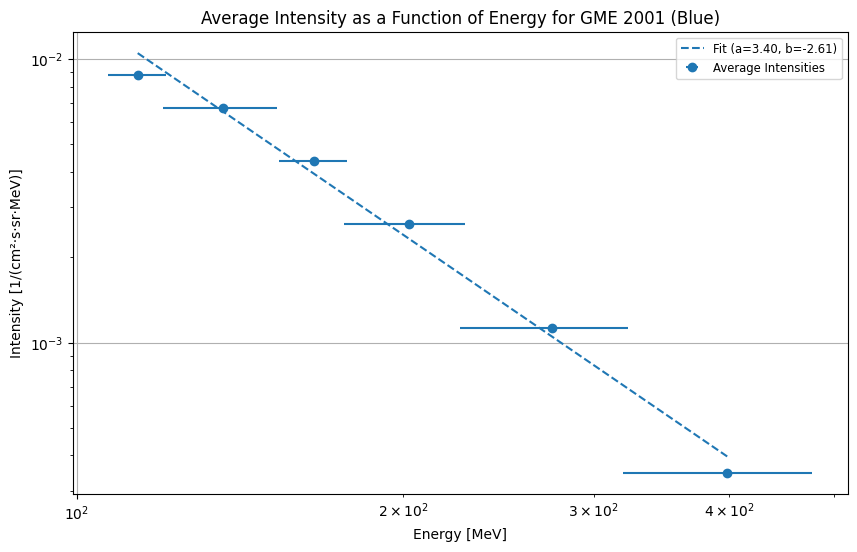

In [20]:
df_slice_NaN = pd.concat([data_2001.iloc[1115:1206]])  # Adjust the slicing as needed
df_copy = df_slice_NaN.copy()

# Extract energies and their ranges
energy_columns = df_slice_NaN.columns[25:31]
energy_ranges = np.array([7.0, 16.5, 12.0, 26.0, 48.5, 79.0])  # Your predefined energy_ranges as an array
erne_ac1 = df_slice_NaN.iloc[:, 32]  # Assuming erne_ac1 column is at index 32
erne_tot = df_slice_NaN.iloc[:, 31]  # Assuming erne_tot column is at index 31

# Prepare the plot
plt.figure(figsize=(10, 6))

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Lists to store data for the matrix
times = []
a_coeffs = []
b_coeffs = []
erne_ac1_values = []
erne_tot_values = []

# Set values to NaN where the index is not in the matching indices set
for col, indices in zip(energy_columns, matching_indices_sets):
    df_copy.loc[~df_copy.index.isin(indices), col] = np.nan

# Calculate the average intensities for each energy column
average_intensities = df_copy[energy_columns].mean()

# Plot the average intensities with error bars
plt.errorbar(
    energy_columns.astype(float),  # Convert column names to floats if they are not already
    average_intensities,
    xerr=energy_ranges,  # Use energy_ranges directly for error bars
    fmt='o',  # 'o' for dots, no connecting lines
    color=colors[0],  # Use the first color
    label='Average Intensities'
)

# Perform linear fit in log-log space for average intensities
mask = ~average_intensities.isna()  # Mask for valid intensities (not NaN)
if mask.any():  # Check if there are any valid data points
    log_energies = np.log10(energy_columns[mask].astype(float))
    log_intensities = np.log10(average_intensities[mask])
    coeffs = np.polyfit(log_energies, log_intensities, 1)
    fit_intensities = 10 ** np.polyval(coeffs, log_energies)

    # Plot the linear fit with the same color
    plt.plot(energy_columns[mask].astype(float), fit_intensities, linestyle='--', color=colors[0],
             label=f'Fit (a={coeffs[1]:.2f}, b={coeffs[0]:.2f})')

    # Store data for matrix
    times.append(df_copy.index[0])  # Assuming you want to use the first index for time
    a_coeffs.append(coeffs[1])
    b_coeffs.append(coeffs[0])
    erne_ac1_values.append(erne_ac1.mean())  # Use the mean of erne_ac1 values
    erne_tot_values.append(erne_tot.mean())  # Use the mean of erne_tot values

# Create DataFrame for the saved data
intensfun_2001_blue = pd.DataFrame({
    'energy': energy_columns.astype(float),
    'average_intensity': average_intensities,
    'energy_range': energy_ranges,
    'a_coeff': [a_coeffs[0]] * len(energy_columns),  # Repeat the coefficient for each energy
    'b_coeff': [b_coeffs[0]] * len(energy_columns),  # Repeat the coefficient for each energy
    'erne_ac1': [erne_ac1_values[0]] * len(energy_columns),  # Repeat the value for each energy
    'erne_tot': [erne_tot_values[0]] * len(energy_columns)  # Repeat the value for each energy
})

# Save the DataFrame to CSV
intensfun_2001_blue.to_csv('intensfun_2001_blue.csv', index=False)

# Set logarithmic scales
plt.xscale('log')
plt.yscale('log')

# Labels and title
plt.xlabel('Energy [MeV]')
plt.ylabel('Intensity [1/(cm²·s·sr·MeV)]')
plt.title('Average Intensity as a Function of Energy for GME 2001 (Blue)')

# Legend and grid
plt.legend(loc='upper right', fontsize='small')
plt.grid(True)

# Show plot
plt.show()

#### Example: Read the CSV file

The following code is an example of how to, after saving the CSV file, read and plot it.

- The previously saved `intensfun_2001_blue.csv` file is read back into a DataFrame.
- Extracted energy and intensity values are plotted with error bars.
- The stored fit parameters are used to reconstruct the log-log fit.
- The final visualization summarizes the intensity distribution across energy levels.

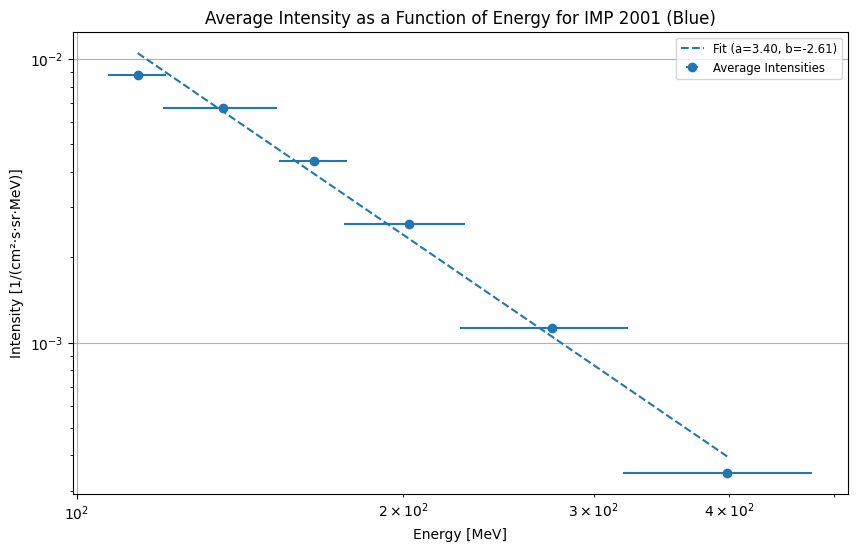

In [21]:
# Read the CSV file
intensfun_2001_blue = pd.read_csv('intensfun_2001_blue.csv')

# Extract columns
energy = intensfun_2001_blue['energy']
average_intensity = intensfun_2001_blue['average_intensity']
energy_range = intensfun_2001_blue['energy_range']
a_coeff = intensfun_2001_blue['a_coeff'].iloc[0]  # Assuming all values are the same
b_coeff = intensfun_2001_blue['b_coeff'].iloc[0]  # Assuming all values are the same

# Prepare the plot
plt.figure(figsize=(10, 6))

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Plot the average intensities with error bars
plt.errorbar(
    energy,  # Energy values
    average_intensity,  # Average intensities
    xerr=energy_range,  # Energy ranges for error bars
    fmt='o',  # 'o' for dots, no connecting lines
    color=colors[0],  # Use the first color
    label='Average Intensities'
)

# Perform linear fit in log-log space for average intensities
mask = ~average_intensity.isna()  # Mask for valid intensities (not NaN)
if mask.any():  # Check if there are any valid data points
    log_energies = np.log10(energy[mask].astype(float))
    log_intensities = np.log10(average_intensity[mask])
    fit_intensities = 10 ** np.polyval([b_coeff, a_coeff], log_energies)

    # Plot the linear fit with the same color
    plt.plot(energy[mask].astype(float), fit_intensities, linestyle='--', color=colors[0],
             label=f'Fit (a={a_coeff:.2f}, b={b_coeff:.2f})')

# Set logarithmic scales
plt.xscale('log')
plt.yscale('log')

# Labels and title
plt.xlabel('Energy [MeV]')
plt.ylabel('Intensity [1/(cm²·s·sr·MeV)]')
plt.title('Average Intensity as a Function of Energy for IMP 2001 (Blue)')

# Legend and grid
plt.legend(loc='upper right', fontsize='small')
plt.grid(True)

# Show plot
plt.show()

---

## Calculate values of `c`

In this section, we extract and process intensity values at specific energy levels (`165.57 MeV` and `202.34 MeV`) to compute a derived parameter `c`. Filtering out outliers, we select the `events` GME intensity `y` and ERNE count `x`, which in this specific case is `"AC1 (D1>1.3MeV)"`. The approach is:
- Define a **function** `compute_c(energy_col, match_index, dataset)` to automate calculations.
- Extract relevant rows using `matching_indices_sets` for each energy level.
- Select the corresponding energy intensity values and six additional columns from the dataset.
- Compute `c` using:
    - $a=\sum \frac{1}{y_i}$ (sum of reciprocals of intensity values).
    - $b=\sum \frac{x_i}{y^2_i}$ (weighted sum of auxiliary variable `AC1`).
    - $c= \frac{a}{b}$ (final calculation).
- Prevent division by zero by replacing `0` values with `NaN`.
- Print the computed values.

In [22]:
# Define a function to compute c-value and return the filtered dataset
def compute_c(energy_col, match_index, dataset):
    # Filter intensity data
    filtered_sub_df = dataset.loc[dataset.index.isin(match_index), [energy_col]]

    # Retrieve the last 6 columns for the same indices
    last_6_columns_filtered = dataset.loc[filtered_sub_df.index, dataset.columns[-6:]]

    # Combine filtered intensity values with last 6 columns
    combined_data = pd.concat([filtered_sub_df, last_6_columns_filtered], axis=1)

    # Extract x and y
    y = combined_data[energy_col]
    x = combined_data["AC1 (D1>1.3MeV)"]

    # Handle division by zero
    if (y == 0).any():
        print(f"Warning: Zero values encountered in {energy_col}. Calculation may be invalid.")
        y = y.replace(0, float('nan'))  # Replace zeros with NaN to prevent errors

    # Compute `c`
    a = (1 / y).sum()
    b = (x / (y**2)).sum()
    c = a / b

    return c, combined_data

# Apply the function for both energy levels
c_165, Data_165_57 = compute_c("165.57", matching_indices_sets[3], data_2001)
c_202, Data_202_34 = compute_c("202.34", matching_indices_sets[4], data_2001)

# Print results with improved formatting
print(f"Energy: 165.57 MeV | Year: 2001 | c-value: {c_165:.6f}")
print(f"Energy: 202.34 MeV | Year: 2001 | c-value: {c_202:.6f}")

Energy: 165.57 MeV | Year: 2001 | c-value: 0.002830
Energy: 202.34 MeV | Year: 2001 | c-value: 0.001739


---

## Correlation Fit With ERNE rate and GME intensity

This section performs the correlation analysis between **ERNE** rate and **GME** intensity for two energy levels: `165.57 MeV` and `202.34 MeV`. The steps are:

1. **Extract Data**
- The selected intensity column (`165.57` or `202.34` MeV) is used as `y`.
- The ERNE rate (`AC1 (D1>1.3MeV)`) is used as `x`.
  
2. **Calculate Measurement Uncertainty (`sigma`)**
- The uncertainty (`sigma`) is estimated as 10% of intensity values (`$y / 10$`).
  
3. **Data Conversion**
- Convert Pandas Series to NumPy arrays to ensure numerical stability.
- Use `np.asarray()` to explicitly cast data to `float64`.
  
4. **Weighted Linear Regression**
- A weighted least squares fit is performed using `LinearRegression().fit()`, with `sigma` as sample weights.
- This accounts for variations in measurement uncertainty.
  
5. **Fit Parameters & R$^{2}$ Calculation**
- The slope (`c`), intercept (`b`), and coefficient of determination (R$^{2}$) are computed.
- R$^{2}$ quantifies how well the linear model explains the data.
  
6. **Visualization with Error Bars**
- Data points are plotted with error bars representing measurement uncertainty.
- The fitted regression line is overlaid in red.

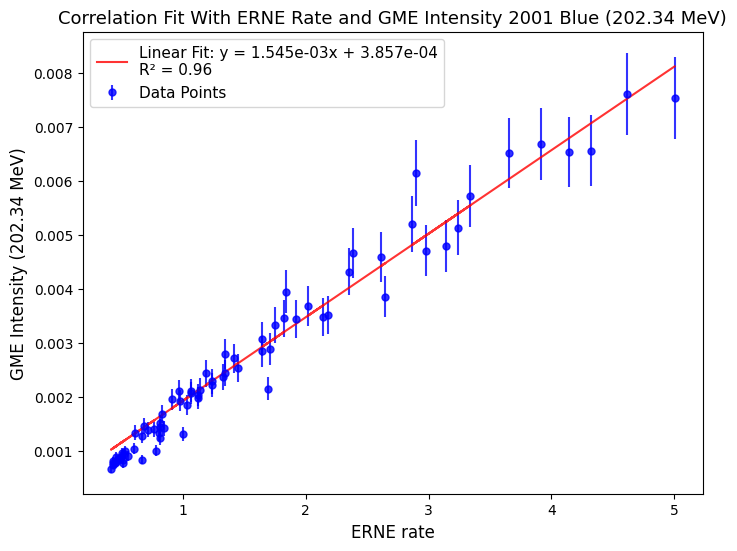

Linear Fit Parameters for 202.34 MeV:
Slope (c): 1.545e-03, Intercept (b): 3.857e-04, R²: 0.96



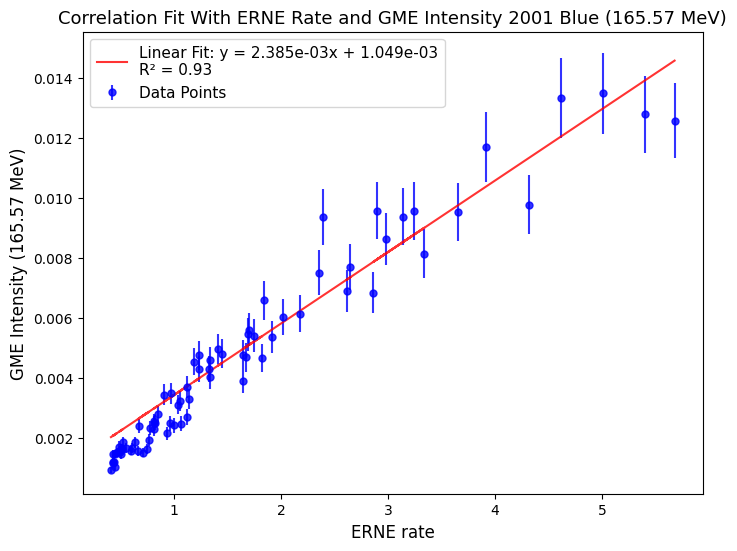

Linear Fit Parameters for 165.57 MeV:
Slope (c): 2.385e-03, Intercept (b): 1.049e-03, R²: 0.93



In [23]:
def correlation_fit(data, energy_col, x_col, title, xlabel, ylabel):
    """Performs a weighted linear regression and plots correlation."""
    
    # Extract GME intensity (y) and ERNE rate (x)
    y = data[energy_col]
    x = data[x_col]
    
    # Calculate measurement uncertainty (sigma)
    sigma = y / 10
    
    # Convert to NumPy arrays and ensure numeric values
    x, y, sigma = map(lambda v: np.asarray(v, dtype=np.float64), [x, y, sigma])
    
    # Weighted Linear Regression
    reg = LinearRegression().fit(x.reshape(-1, 1), y, sample_weight=np.abs(sigma))
    c, b = reg.coef_[0], reg.intercept_
    r_squared = r2_score(y, reg.predict(x.reshape(-1, 1)), sample_weight=np.abs(sigma))
    
    # Plot results
    plt.figure(figsize=(8, 6))
    plt.errorbar(x, y, yerr=np.abs(sigma), fmt='o', color='blue', label='Data Points', alpha=0.8, markersize=5)
    plt.plot(x, c * x + b, color='red', 
             label=f'Linear Fit: y = {c:.3e}x + {b:.3e}\nR² = {r_squared:.2f}', 
             alpha=0.8, linewidth=1.5) # Increased linewidth for visibility
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.title(title, fontsize=13)
    plt.legend(fontsize=11)
    #plt.savefig(-)
    plt.show()
    
    print(f'Linear Fit Parameters for {energy_col} MeV:')
    print(f'Slope (c): {c:.3e}, Intercept (b): {b:.3e}, R²: {r_squared:.2f}\n')
    
# Apply function for both energy levels
correlation_fit(Data_202_34, "202.34", "AC1 (D1>1.3MeV)",
                "Correlation Fit With ERNE Rate and GME Intensity 2001 Blue (202.34 MeV)",
                "ERNE rate", "GME Intensity (202.34 MeV)")

correlation_fit(Data_165_57, "165.57", "AC1 (D1>1.3MeV)",
                "Correlation Fit With ERNE Rate and GME Intensity 2001 Blue (165.57 MeV)",
                "ERNE rate", "GME Intensity (165.57 MeV)")

---

## Orthogonal Distance Regression

This section applies Orthogonal Distance Regression (ODR) to model the relationship between ERNE counting rates and GME intensities for two energy channels. ODR is used instead of standard regression because it accounts for uncertainties in both dependent and independent variables.

- `data` (pd.DataFrame): Input data containing intensity, rate, and count columns.
- `intensity_col` (str): Column name for intensity values (GME).
- `rate_col` (str): Column name for ERNE counting rate.
- `count_col` (str): Column name for ERNE event counts.
- `energy_label` (str): Label for plot titles.
- `save_path` (str): File path to save the figure.

202.34 MeV ODR Fit:
Slope (a) = 1.700e-03 ± 4.749e-05
Intercept (b) = 2.768e-05 ± 3.796e-05



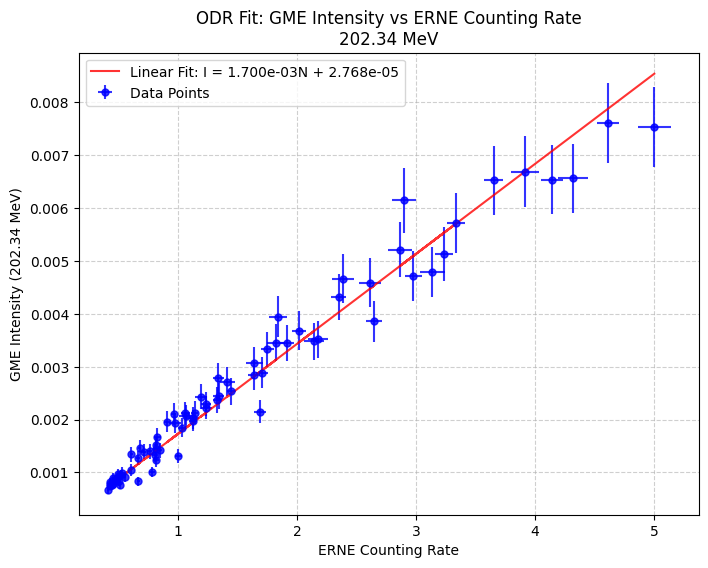

165.57 MeV ODR Fit:
Slope (a) = 2.820e-03 ± 9.162e-05
Intercept (b) = 1.246e-05 ± 7.376e-05



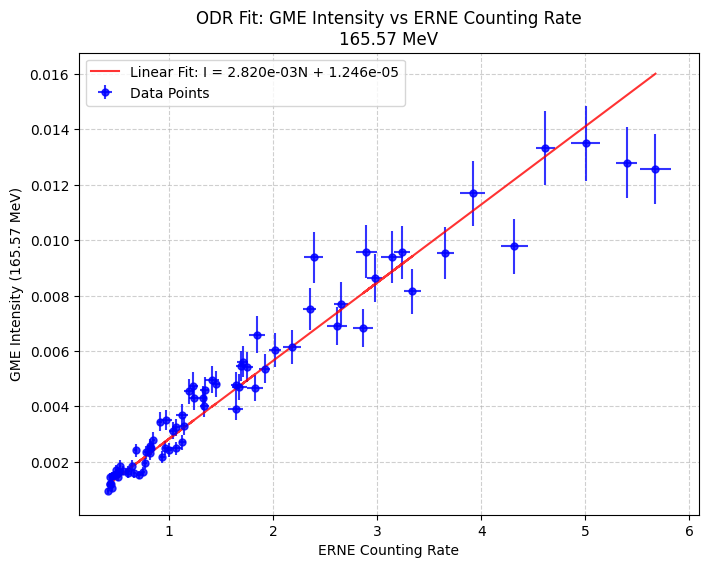

In [24]:
def linear_model(B, x):
    return B[0] * x + B[1]

def perform_odr_regression(data, intensity_col, rate_col, count_col, energy_label, save_path):
    """Performs ODR regression and plot the results"""
    # Extract numerical values
    I = data[intensity_col].values # GME intensity
    N = data[rate_col].astype(float).values # Counting rate
    B = data[count_col].values  # Number of counts
    
    # Compute errors
    sigma_N = (1 / np.sqrt(B)) * N  # Error in counting rate
    sigma_I = 0.1 * I  # Assumed 10% error in intensity
    
    # Define data for ODR
    real_data = RealData(N, I, sx=sigma_N, sy=sigma_I)
    model = Model(linear_model)
    odr = ODR(real_data, model, beta0=[1.0, 0.0])
    output = odr.run()
    
    # Extract fit parameters
    a, b = output.beta
    a_err, b_err = output.sd_beta
    
    # Print results
    print(f"{energy_label} MeV ODR Fit:")
    print(f"Slope (a) = {a:.3e} ± {a_err:.3e}")
    print(f"Intercept (b) = {b:.3e} ± {b_err:.3e}\n")
    
    # Predicted values
    I_pred = linear_model([a, b], N)
    
    # Plot results
    plt.figure(figsize=(8, 6))
    plt.errorbar(N, I, xerr=sigma_N, yerr=sigma_I, fmt='o', color='blue', label='Data Points', alpha=0.8, markersize=5)
    plt.plot(N, I_pred, color='red', label=f'Linear Fit: I = {a:.3e}N + {b:.3e}', alpha=0.8, linewidth=1.5)
    plt.xlabel('ERNE Counting Rate')
    plt.ylabel(f'GME Intensity ({energy_label} MeV)')
    plt.title(f'ODR Fit: GME Intensity vs ERNE Counting Rate\n{energy_label} MeV')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    #plt.savefig(save_path, format='png', dpi=300, bbox_inches='tight')
    plt.show()

# Apply ODR to both energy channels
perform_odr_regression(Data_202_34, "202.34", "AC1 (D1>1.3MeV)", "count AC1 (D1>1.3MeV)", "202.34", "ODR_fit_202_34.png")
perform_odr_regression(Data_165_57, "165.57", "AC1 (D1>1.3MeV)", "count AC1 (D1>1.3MeV)", "165.57", "ODR_fit_165_57.png")

---

# 📊 Analyzing Results  

In this section we show an example of how to analyze the results, using the events that we picked. The goal is to examine the variation in calibration values, compute chi-squared statistics, and visualize results.

## 🔎 Measuring Chi-Squared ($\chi^2$) 

The chi-squared ($\chi^2$) value is used to measure the deviation of the $ m $-values from 1, considering their uncertainties. It is computed for each energy channel as follows:

$
\chi^2 = \frac{1}{N} \sum_{i} \frac{(m_i - 1)^2}{\sigma_i^2}
$

where:
- $ m_i $ is the measured $ m $-value for a given event (calculated in section [RANSAC](##RANSAC)),
- $ \sigma_i $ is the corresponding error (uncertainty) in $ m_i $,
- $ N $ is the number of valid measurements (non-NaN values) for that energy.

#### Steps in the Code:
1. Iterate through each energy level.
2. For each energy, sum up the squared deviations of $ m_i $ from 1, weighted by the inverse squared error.
3. Normalize by the number of valid measurements to avoid bias from missing values.
4. Store the computed $\chi^2$ value in a new column.

This helps us understand how well the $ m $-values align with 1 across different energy levels while considering their uncertainties.

In [25]:
m_values = {
    "Energy MeV": [89.71, 113.78, 136.51, 165.57, 202.34, 274.24, 398.24],
    "[2001 Green]": [0.6951, 0.8280, 0.8768, 0.9056, 0.9633, None, None], 
    "[2001 Blue]": [0.9989, 0.9445, 0.9340, 0.9734, 0.9709, 1.0157, 1.1893],
    "[2001 Orange]": [0.9438, 0.8920, 0.8614, 0.8861, 0.8927, 0.8681, 0.7684], 
    "[1997 Purple]": [0.8102, 0.8595, 0.8593, 1.0088, 0.9771, 1.4245, 2.4083], 
    "[1998 Red]": [0.6659, 0.8994, 0.8954, 0.9689,  0.8809, 1.2997, 1.3866],
}

# Corresponding errors for each measurement
error_values = {
    "[2001 Green] Error": [0.0148, 0.0177, 0.0148, 0.0206, 0.0280, None, None],
    "[2001 Blue] Error": [0.0316, 0.0184, 0.0138, 0.0240, 0.0199, 0.0172, 0.0336],
    "[2001 Orange] Error": [0.0121, 0.0104, 0.0115, 0.0098, 0.0120, 0.0113, 0.0142],
    "[1997 Purple] Error": [0.0178, 0.0103, 0.0105, 0.0151, 0.0138, 0.0287, 0.0841],
    "[1998 Red] Error": [0.0166, 0.0244, 0.0236, 0.0275, 0.0239, 0.0322, 0.0581],
}

# Make the df from m_values
df_m = pd.DataFrame(m_values)

# Add the error columns to the DataFrame
for key, values in error_values.items():
    df_m[key] = values

# Define the function to calculate chi-squared for each row
def calculate_chi_squared(row):
    chi_squared = 0
    valid_measurements = 0
    for col in m_values.keys():
        if col == "Energy MeV":
            continue  # Skip Energy column
        m_value = row[col]
        error_value = row[f"{col} Error"]
        if pd.notna(m_value) and pd.notna(error_value): # NaN values
            chi_squared += ((m_value - 1) ** 2) / (error_value ** 2)
            valid_measurements += 1
    # Normalizing by the number of valid measurements
    if valid_measurements > 0:
        chi_squared *= (1 / valid_measurements)
    return chi_squared

# Apply the function 
df_m["Chi Squared"] = df_m.apply(calculate_chi_squared, axis=1)

# Define function to calculate the average m values for each energy
def calculate_average_m_values(row):
    m_sum = 0
    valid_measurements = 0
    for col in m_values.keys():
        if col == "Energy MeV":
            continue  # Skip Energy column
        m_value = row[col]
        if pd.notna(m_value):
            m_sum += m_value
            valid_measurements += 1
    # Return the average if there are valid measurements
    if valid_measurements > 0:
        return m_sum / valid_measurements
    return None

# Apply the function to each row and create a new column for the average m values
df_m["m arvon keskiarvo"] = df_m.apply(calculate_average_m_values, axis=1)

print(df_m)

   Energy MeV  [2001 Green]  [2001 Blue]  [2001 Orange]  [1997 Purple]  \
0       89.71        0.6951       0.9989         0.9438         0.8102   
1      113.78        0.8280       0.9445         0.8920         0.8595   
2      136.51        0.8768       0.9340         0.8614         0.8593   
3      165.57        0.9056       0.9734         0.8861         1.0088   
4      202.34        0.9633       0.9709         0.8927         0.9771   
5      274.24           NaN       1.0157         0.8681         1.4245   
6      398.24           NaN       1.1893         0.7684         2.4083   

   [1998 Red]  [2001 Green] Error  [2001 Blue] Error  [2001 Orange] Error  \
0      0.6659              0.0148             0.0316               0.0121   
1      0.8994              0.0177             0.0184               0.0104   
2      0.8954              0.0148             0.0138               0.0115   
3      0.9689              0.0206             0.0240               0.0098   
4      0.8809         

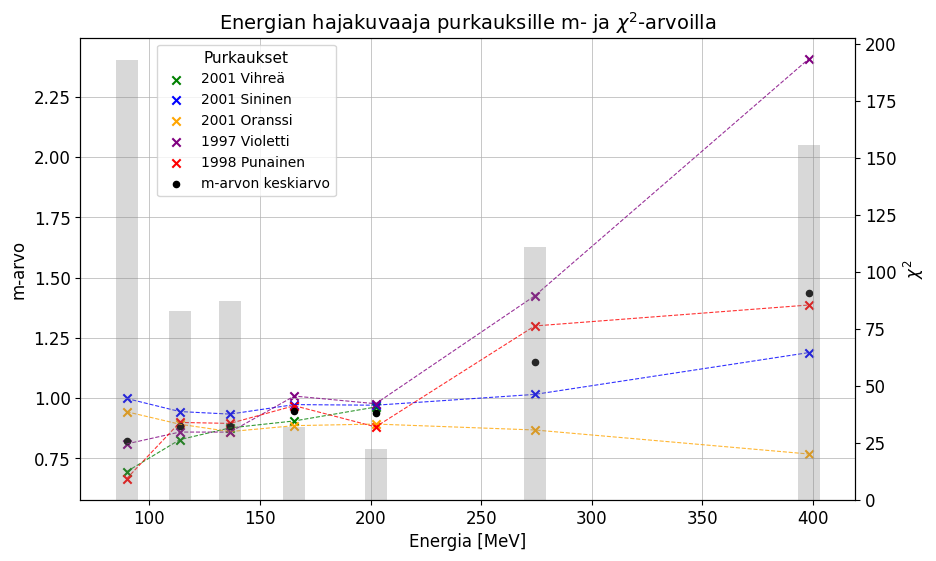

In [27]:
# Create a new figure and axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Scatter plot for each event with different colors
ax1.scatter(df_m["Energy MeV"], df_m["[2001 Green]"], color='green', label='2001 Vihreä', marker='x')
ax1.scatter(df_m["Energy MeV"], df_m["[2001 Blue]"], color='blue', label='2001 Sininen', marker='x')
ax1.scatter(df_m["Energy MeV"], df_m["[2001 Orange]"], color='orange', label='2001 Oranssi', marker='x')
ax1.scatter(df_m["Energy MeV"], df_m["[1997 Purple]"], color='purple', label='1997 Violetti', marker='x')
ax1.scatter(df_m["Energy MeV"], df_m["[1998 Red]"], color='red', label='1998 Punainen', marker='x')

# Adding faint dashed lines for each event
ax1.plot(df_m["Energy MeV"], df_m["[2001 Green]"], color='green', linestyle='--', linewidth=0.8, alpha=0.8)
ax1.plot(df_m["Energy MeV"], df_m["[2001 Blue]"], color='blue', linestyle='--', linewidth=0.8, alpha=0.8)
ax1.plot(df_m["Energy MeV"], df_m["[2001 Orange]"], color='orange', linestyle='--', linewidth=0.8, alpha=0.8)
ax1.plot(df_m["Energy MeV"], df_m["[1997 Purple]"], color='purple', linestyle='--', linewidth=0.8, alpha=0.8)
ax1.plot(df_m["Energy MeV"], df_m["[1998 Red]"], color='red', linestyle='--', linewidth=0.8, alpha=0.8)

# Plotting the average m values as points
ax1.scatter(df_m["Energy MeV"], df_m["m arvon keskiarvo"], color='black', marker='o', label='m-arvon keskiarvo', s=20)

# Labeling the left y-axis
ax1.set_xlabel('Energia [MeV]', fontsize=12)
ax1.set_ylabel('m-arvo', fontsize=12)
ax1.tick_params(axis='both', which='major', labelsize=12)

# Adding Chi Squared symbol in the title and y-axis label
ax1.set_title(r'Energian hajakuvaaja purkauksille m- ja $\chi^2$-arvoilla', fontsize=14)

# Create a secondary y-axis for Chi Squared values
ax2 = ax1.twinx()
ax2.set_ylabel(r'$\chi^2$', fontsize=12)
ax2.tick_params(axis='both', which='major', labelsize=12)

# Plot the Chi Squared values as a bar plot with semi-transparent bars
bar_width = 10  # MeV
ax2.bar(df_m["Energy MeV"], df_m["Chi Squared"], width=bar_width, color='gray', alpha=0.3, align='center')

# Adding a legend for the scatter plots with transparent background
ax1.legend(loc='upper left', bbox_to_anchor=(0.09, 1), title='Purkaukset', fontsize='10', title_fontsize = '11')

# Add grid lines aligned with the primary y-axis (m value)
ax1.grid(True, which='both', linestyle='-', linewidth=0.5)

# Save the plot to a file
#plt.savefig('scatter_intensity_vs_mvalue_chi.png', format='png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

## 📈 Average intensity as a function of energy

Next we will analyze the average intensity as a function of energy for each event. Here we average the intesity of each event in a given energy channel. We start off by reading the corresponding CSV file (`intensfun_2001_blue.csv`) that we saved in the [third example](#Third-Example) of [Intensity as a Function of Energy](#Intensity-as-a-Function-of-Energy) section, combining each event into a single graph. The files `intensfun_2001_Orange.csv`, `intensfun_2001_green.csv`, `intensfun_1997.csv` and `intensfun_1998_red.csv` are provided ready made and were made from the other events we analyzed. 

<div class="alert alert-block alert-danger">
<b>Note!:</b> Our example includes a bit of code that excludes one events energy channel and the corresponding intensity.
</div>

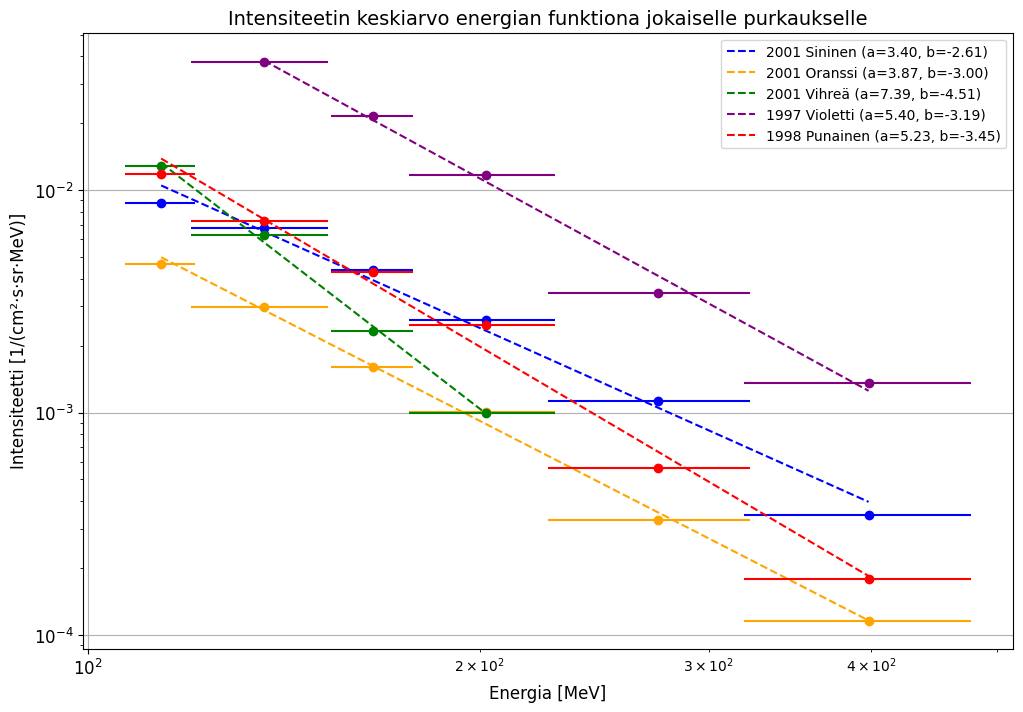

In [28]:
# Define a function to read the CSV file and return the relevant data
def read_csv_data(filename):
    df = pd.read_csv(filename)
    energy = df['energy']
    average_intensity = df['average_intensity']
    energy_range = df['energy_range']
    a_coeff = df['a_coeff'].iloc[0]  # Assuming all values are the same
    b_coeff = df['b_coeff'].iloc[0]  # Assuming all values are the same
    return energy, average_intensity, energy_range, a_coeff, b_coeff

# List of files and their corresponding colors
files_and_colors = [
    ('intensfun_2001_blue.csv', 'blue'),
    ('intensfun_2001_Orange.csv', 'orange'),
    ('intensfun_2001_green.csv', 'green'),
    ('intensfun_1997.csv', 'purple'),
    ('intensfun_1998_red.csv', 'red')
]

# Dictionary mapping filenames to desired legend labels
filename_to_label = {
    'intensfun_2001_blue.csv': '2001 Sininen',
    'intensfun_2001_Orange.csv': '2001 Oranssi',
    'intensfun_2001_green.csv': '2001 Vihreä',
    'intensfun_1997.csv': '1997 Violetti',
    'intensfun_1998_red.csv': '1998 Punainen'
}

# Prepare the plot
plt.figure(figsize=(12, 8))

# Loop through each file and plot the data
for filename, color in files_and_colors:
    energy, average_intensity, energy_range, a_coeff, b_coeff = read_csv_data(filename)
    
    # Mask to handle valid (non-NaN) intensities
    mask = ~average_intensity.isna()  # Mask for valid intensities (not NaN)
    
    if filename == 'intensfun_1997.csv':
        # Exclude the first energy value and the corresponding intensity
        energy = energy.iloc[1:]  # Exclude the first energy value
        average_intensity = average_intensity.iloc[1:]  # Exclude the first intensity value
        energy_range = energy_range.iloc[1:]  # Exclude the corresponding energy range
        mask = mask.iloc[1:]  # Exclude the first value from the mask as well
    
    # Plot the average intensities with error bars, without adding to the legend
    plt.errorbar(
        energy,  # Energy values
        average_intensity,  # Average intensities
        xerr=energy_range,  # Energy ranges for error bars
        fmt='o',  # 'o' for dots, no connecting lines
        color=color  # Use the specified color
    )
    
    if mask.any():  # Check if there are any valid data points after exclusion
        # Apply the mask for valid values
        energy_valid = energy[mask]
        average_intensity_valid = average_intensity[mask]
        
        # Recalculate the linear fit in log-log space
        log_energies = np.log10(energy_valid.astype(float))
        log_intensities = np.log10(average_intensity_valid)
        
        # Perform a new linear fit in the log-log space
        b_coeff, a_coeff = np.polyfit(log_energies, log_intensities, 1)  # Linear regression
        
        # Generate the fit line from the new coefficients
        fit_intensities = 10 ** np.polyval([b_coeff, a_coeff], log_energies)

        # Plot the new linear fit with the same color and add to the legend
        plt.plot(energy_valid.astype(float), fit_intensities, linestyle='--', color=color,
                 label=f'{filename_to_label[filename]} (a={a_coeff:.2f}, b={b_coeff:.2f})')
        
# Set logarithmic scales
plt.xscale('log')
plt.yscale('log')

# Labels and title
plt.xlabel('Energia [MeV]', fontsize=12)
plt.ylabel('Intensiteetti [1/(cm²·s·sr·MeV)]', fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.title('Intensiteetin keskiarvo energian funktiona jokaiselle purkaukselle', fontsize=14)

# Legend and grid
plt.legend(loc='upper right', fontsize='10')
plt.grid(True)

# Save the plot to a file
#plt.savefig('intensity_as_function.png', format='png', dpi=300, bbox_inches='tight')

# Show plot
plt.show()

## 📊 Compiling & Analyzing Calibration Coefficients  

Lastly, we gather **a-values** and **c-values** calculated in the [ORD](##Orthogonal-Distance-Regression) and [calculating values of `c`](##-Calculate-values-of-`c`) sections and: 

✔ **Calculate their mean & standard deviation**  
✔ **Assess consistency across events**

In [29]:
# Define values of c
df_c = pd.DataFrame({
    "Energy MeV": [165.57, 202.34],
    "[2001 Green]": [0.0002503935552752231, 0.00035081828945412297], # Peak
    "[2001 Blue]": [0.0028299279264458145, 0.0017387591048910044],   # Tail
    "[2001 Orange]": [0.0037497710130281994, 0.0020864417592687118], # Tail
    "[1997 Purple]": [0.0003847427281715629, 0.0004899816741625574], # Peak unisotropic high intensities -> c lower
    "[1998 Red]": [0.0016504119538233778, 0.0009587108953451347],    # Peak
})

# Define values of a
df_a = pd.DataFrame({
    "Energy MeV": [165.57, 202.34],
    "[2001 Green]": [8.455e-04, 2.486e-04], 
    "[2001 Blue]": [2.820e-03, 1.700e-03],   
    "[2001 Orange]": [2.439e-03, 1.396e-03], 
    "[1997 Purple]": [9.548e-04, 4.234e-04], 
    "[1998 Red]": [1.483e-03, 7.203e-04], 
})

# Define errors
df_errors = pd.DataFrame({
    "[2001 Green] Error": [6.324e-05, 1.662e-05],
    "[2001 Blue] Error": [9.162e-05, 4.749e-05],
    "[2001 Orange] Error": [4.909e-05, 2.978e-05],
    "[1997 Purple] Error": [2.925e-05, 1.483e-05],
    "[1998 Red] Error": [4.791e-05, 2.107e-05],
})

# Function to calculate statistics
def compute_statistics(df):
    df["Average"] = df.iloc[:, 1:].mean(axis=1)
    df["StdDev"] = df.iloc[:, 1:].std(axis=1)
    return df

# Compute statistics for c and a
df_c = compute_statistics(df_c)
df_a = compute_statistics(pd.concat([df_a, df_errors], axis=1))

# Formatting dictionary
format_dict = {col: "{:.3e}" for col in df_c.columns if col != "Energy MeV"}
format_dict["Energy MeV"] = "{:.2f}"

# Display results
print("c-values with individual averages and standard deviations:")
display(df_c.style.format(format_dict))

print("a-values with individual averages and standard deviations:")
display(df_a.style.format(format_dict))

c-values with individual averages and standard deviations:


a-values with individual averages and standard deviations:
